<a href="https://colab.research.google.com/github/wonyoung-ji/goyangfifteen/blob/master/Goyang_Public_bicycles_EDA_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 준비

In [ ]:
# 나눔폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 런타임 다시 시작

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (8,485 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

## (1) 구글드라이브연동

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## (2) 패키지 호출

In [ ]:
!pip install geopandas
!pip install geojson
!pip install haversine     # 좌표간 거리 구하기
!pip install tqdm

     |████████████████████████████████| 972kB 2.7MB/s 
     |████████████████████████████████| 10.9MB 14.4MB/s 
     |████████████████████████████████| 14.8MB 245kB/s 


In [ ]:
import json
import pandas as pd
import numpy as np
import geojson
from haversine import haversine, Unit
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import missingno as mnso
from shapely.geometry import shape, GeometryCollection, Point
import geopandas as gpd
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook

%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# plt 폰트 설정
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

# EDA 1


## (1) 스테이션과 위치 데이터 결합



### (1).1. 동 

In [ ]:
df_2=pd.read_csv('/content/gdrive/My Drive/고양시피프틴/02.자전거스테이션.csv')
df_2

Station_ID          STATION_NAME  거치대 수량         위도          경도
0           101          어울림마을 701동 앞      20  37.654775  126.834584
1           103          대림e-편한세상106동      20  37.660442  126.840377
2           104               탄현마을8단지      25  37.698523  126.766042
3           105             KT 덕양지사 앞      20  37.655244  126.839261
4           106           원당역 앞 공영주차장      30  37.653410  126.842530
..          ...                   ...     ...        ...         ...
159         350  ★하이파크5단지 502동앞 버스정류장      20  37.697867  126.753089
160         351          ◆일산에듀포레 푸르지오      40  37.702259  126.767231
161         352            ◆꿈에그린203동앞      40  37.666425  126.749244
162         353            ◆꿈에그린106동앞      40  37.666720  126.750784
163         992                ★피프틴센터       4  37.637529  126.833760

[164 rows x 5 columns]

In [ ]:
df_7=pd.read_csv('/content/gdrive/My Drive/고양시피프틴/07.인구통계.csv')

df_7['총인구수']=df_7['총인구수'].str.replace(',', '').astype('float64')
df_7=df_7[df_7['조회기준']=='2019년12월']    # 가장 최신 데이터 사용
df_7=df_7[df_7['총인구수']<=250000]          # 필요없는 데이터 제거
df_7.head()

행정구역      조회기준     총인구수  ...  남자 인구수  여자 인구수 남여 비율
107   경기도 고양시 덕양구 주교동(4128151000)  2019년12월  15748.0  ...   8,126   7,622  1.07
143   경기도 고양시 덕양구 원신동(4128152000)  2019년12월  23942.0  ...  11,568  12,374  0.93
179   경기도 고양시 덕양구 흥도동(4128153000)  2019년12월  44565.0  ...  21,702  22,863  0.95
215  경기도 고양시 덕양구 성사1동(4128154000)  2019년12월  22062.0  ...  10,928  11,134  0.98
251  경기도 고양시 덕양구 성사2동(4128155000)  2019년12월  11729.0  ...   5,689   6,040  0.94

[5 rows x 8 columns]

In [ ]:
geo_path_34="/content/gdrive/My Drive/고양시피프틴/34.행정경계(행정동기준).geojson"
geo_str_34=geojson.load(open(geo_path_34,encoding='utf-8'))

In [ ]:
point= [Point(xy) for xy in zip(df_2.경도, df_2.위도)]  # 모든 스테이션의 (경도, 위도)를 가지고 있음

dong=[]
id=[]

for feature in geo_str_34['features']:                      
    polygon = shape(feature['geometry'])               # geostr내의 행정동 좌표값을 각각 가져와서 polygon 형태로 만듦
    for p in range(len(point)):
      if polygon.contains(point[p]):                    # 행정동이 스테이션의 (경도, 위도)를 가지고 있다면
        dong.append(feature['properties']['행정동명'])  # 그 행정동의 이름을 dong에 넣고
        id.append(df_2['Station_ID'][p])                # 스테이션의 이름을 id에 넣음
        
st_d=pd.DataFrame([dong,id])      # 스테이션별 좌표와, 스테이션이 위치한 동의 이름으로 df만듦
st_d=st_d.T
st_d.columns=['dong','Station_ID']
st_d=st_d[['Station_ID','dong']]
st_d

Station_ID dong
0          146  주교동
1          170  원신동
2          171  원신동
3          172  원신동
4          173  원신동
..         ...  ...
159        346  송산동
160        347  송산동
161        348  송산동
162        349  송산동
163        350  송산동

[164 rows x 2 columns]

### (1).2 구

In [ ]:
df_8=gpd.read_file('/content/gdrive/My Drive/고양시피프틴/08.행정경계(시군구).geojson')
df_8

SIG_CD SIG_KOR_NM                                           geometry
0  41281     고양시덕양구  MULTIPOLYGON (((126.92910 37.74849, 126.92964 ...
1  41285    고양시일산동구  MULTIPOLYGON (((126.77762 37.67899, 126.77825 ...
2  41287    고양시일산서구  MULTIPOLYGON (((126.76703 37.70717, 126.76719 ...

In [ ]:
geo_path_8='/content/gdrive/My Drive/고양시피프틴/08.행정경계(시군구).geojson'
geo_str_8= geojson.load(open(geo_path_8,encoding='utf-8'))

In [ ]:
# 스테이션의 좌표로 '구' 찾기

point= [Point(xy) for xy in zip(df_2.경도, df_2.위도)]  # 모든 스테이션의 (경도, 위도)를 가지고 있음

gu=[]
location=[]
id=[]

for feature in geo_str_8['features']:                      
    polygon = shape(feature['geometry'])               # geostr내의 행정동 좌표값을 각각 가져와서 polygon 형태로 만듦
    for p in range(len(point)):
      if polygon.contains(point[p]):                    # 행정동이 스테이션의 (경도, 위도)를 가지고 있다면
        gu.append(feature['properties']['SIG_KOR_NM'])  # 그 행정구의 이름을 gu에 넣고
        location.append(point[p])                       # 스테이션의 (경도, 위도)를 location에 넣고
        id.append(df_2['Station_ID'][p])                # 스테이션의 이름을 id에 넣음
        
st_g=pd.DataFrame([gu,location,id])      # 스테이션별 좌표와, 스테이션이 위치한 동의 이름으로 df만듦
st_g=st_g.T
st_g.columns=['gu','좌표','Station_ID']
st_g[['Station_ID','좌표','gu']]
st_g=st_g[['Station_ID','gu']]
st_g



Station_ID       gu
0          101   고양시덕양구
1          103   고양시덕양구
2          105   고양시덕양구
3          106   고양시덕양구
4          110   고양시덕양구
..         ...      ...
159        349  고양시일산서구
160        350  고양시일산서구
161        351  고양시일산서구
162        352  고양시일산서구
163        353  고양시일산서구

[164 rows x 2 columns]

### (1).3 구 + 동 + 스테이션의 위치

In [67]:
station=pd.merge(df_2,st_d,on='Station_ID')
station=pd.merge(station,st_g,on='Station_ID')
station=station[['gu','dong','Station_ID','STATION_NAME','거치대 수량','경도','위도']]
station

gu  dong Station_ID  ... 거치대 수량          경도         위도
0     고양시덕양구  성사2동        101  ...     20  126.834584  37.654775
1     고양시덕양구  성사1동        103  ...     20  126.840377  37.660442
2    고양시일산서구   탄현동        104  ...     25  126.766042  37.698523
3     고양시덕양구  성사1동        105  ...     20  126.839261  37.655244
4     고양시덕양구  성사1동        106  ...     30  126.842530  37.653410
..       ...   ...        ...  ...    ...         ...        ...
159  고양시일산서구   송산동        350  ...     20  126.753089  37.697867
160  고양시일산서구   탄현동        351  ...     40  126.767231  37.702259
161  고양시일산서구   대화동        352  ...     40  126.749244  37.666425
162  고양시일산서구   대화동        353  ...     40  126.750784  37.666720
163   고양시덕양구  화정1동        992  ...      4  126.833760  37.637529

[164 rows x 7 columns]

## (2) 스테이션 살펴보기

### (2).1 고양시 스테이션 시각화

In [ ]:
map_station = folium.Map(location=[station['위도'].mean(), station['경도'].mean()], zoom_start=10.8, tiles='CartoDB positron')
folium.GeoJson(geo_str_34).add_to(map_station)

for i, row in station.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=1,
        color='red',
        fill=True,
    ).add_to(map_station)
map_station

- 고양시 행정동별로 나눈 구역도에 스테이션의 위치를 표시하였다.


In [ ]:
map_station_heat = folium.Map(location=[station['위도'].mean(), station['경도'].mean()], zoom_start=10.8, tiles='CartoDB positron')
plugins.HeatMap(station[['위도', '경도']].values.tolist(),
                        radius=10, blur=5
                        ).add_to(map_station_heat)
plugins.Fullscreen(position='topright').add_to(map_station_heat)
map_station_heat

- 유독 두 구역에 밀집도가 높게 표시되는 것을 볼 수 있다.
- 고양시에 전체적으로 스테이션이 위치한 것이 아닌, 어떠한 이유로 인해 특정구역에 밀집하여 위치하고 있다는 것을 알 수 있다.

## (3) 스테이션 개수

### (3).1 동별 스테이션 개수

In [ ]:
map_dong_count = folium.Map(location=[station['위도'].mean(), station['경도'].mean()], zoom_start=11,tiles='cartodbpositron')

folium.Choropleth(geo_data=geo_str_34,
                  data=station,
                  columns=['dong','거치대 수량'],
                  key_on='feature.properties.행정동명', 
                  fill_color='Blues').add_to(map_dong_count)
map_dong_count

- 지역소 대여소 개수
  - 색이 진할수록 해당 지역에 대여소 개수가 많다는 뜻이다.
  - 밀집도가 높은 구역에 당연하게 대여소가 많이 위치해있다.

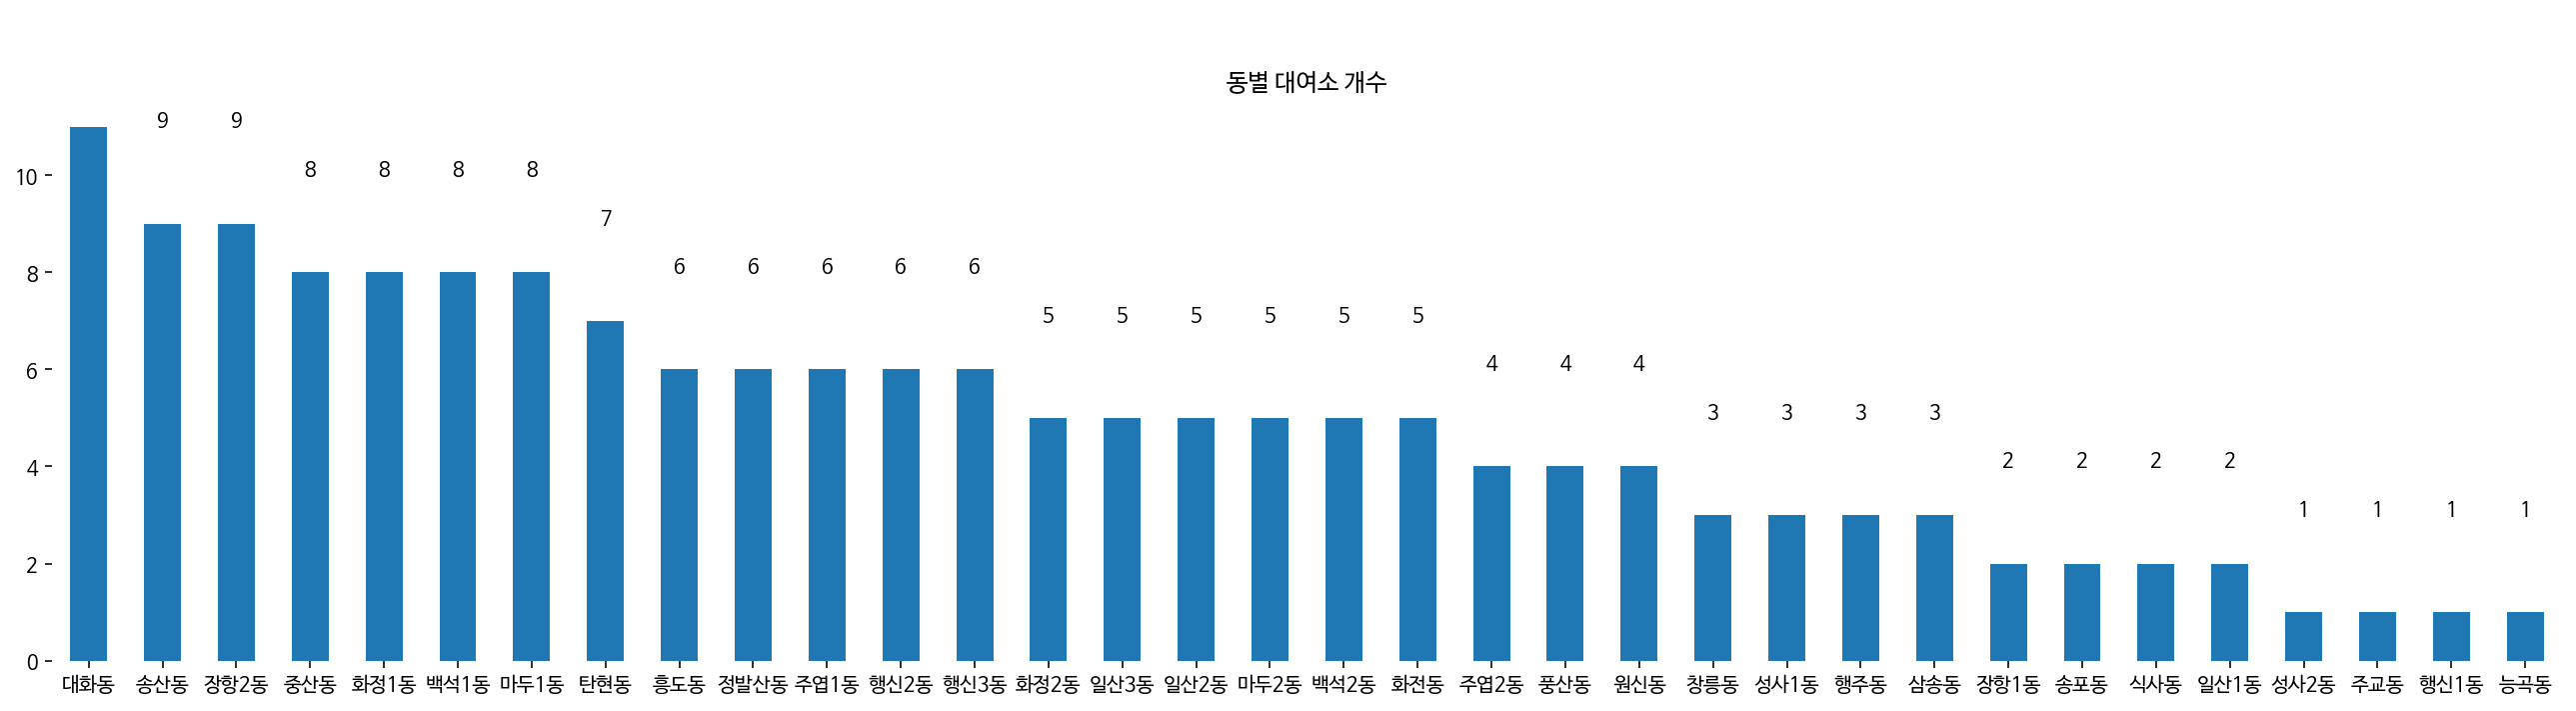

In [ ]:
dong_have_bikes =station.groupby('dong').size()
dong_have_bikes.sort_values(ascending=False, inplace=True)

ax = dong_have_bikes.plot(kind='bar', figsize=(18, 5), rot=0, title="동별 대여소 개수")
for p in ax.patches: 
     left, bottom, width, height = p.get_bbox().bounds 
     ax.annotate("%d"%(height), (left+width/2, height+2), ha='center')
plt.box(False)
plt.xlabel('')
plt.tight_layout()
plt.show()

- 동별로 수치를 통해 자세하게 알아보고자한다.
  - 가장 많은 곳은 [대화동 - 11개]
  - 가장 적은 곳은 [성사2동, 주교동, 행신1동, 능곡동 - 1개]로 분포되어있다.

### (3).2 구별 스테이션 개수

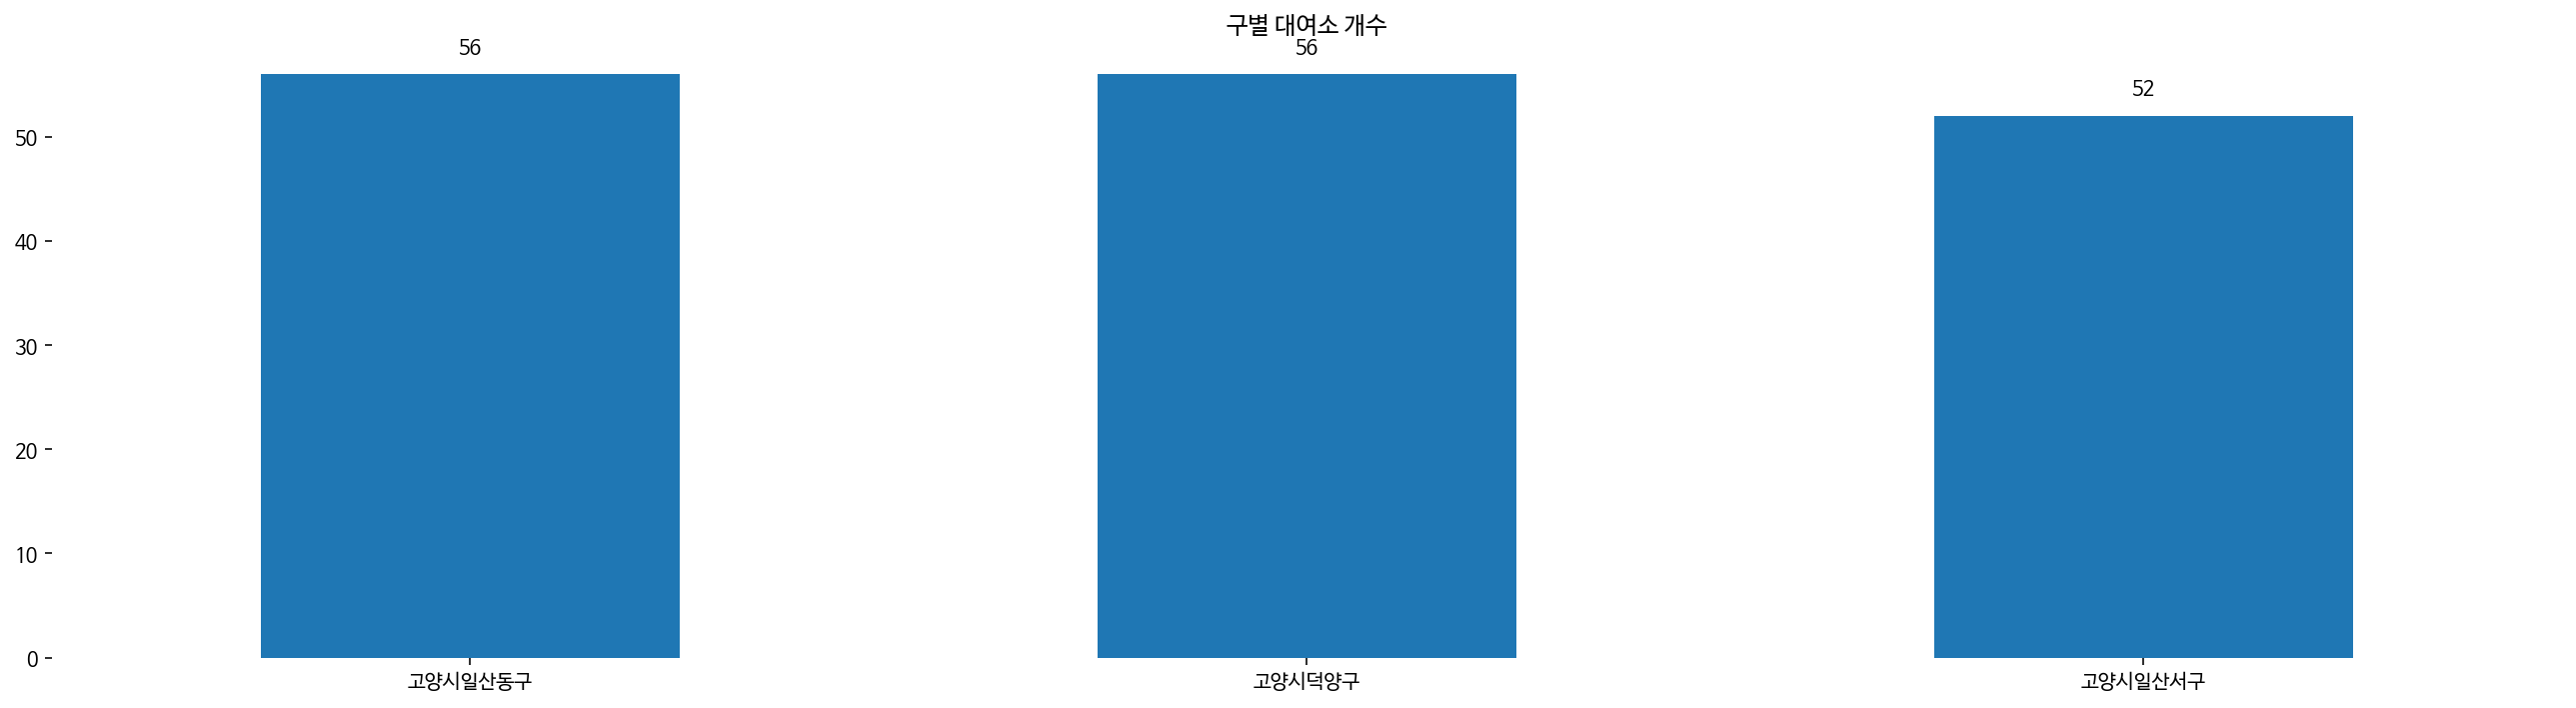

In [ ]:
gu_have_bikes =station.groupby('gu').size()
gu_have_bikes.sort_values(ascending=False, inplace=True)

ax = gu_have_bikes.plot(kind='bar', figsize=(18, 5), rot=0, title="구별 대여소 개수")
for p in ax.patches: 
     left, bottom, width, height = p.get_bbox().bounds 
     ax.annotate("%d"%(height), (left+width/2, height+2), ha='center')
plt.box(False)
plt.xlabel('')
plt.tight_layout()
plt.show()

- 대여소 개수가 동별로는 많은 차이를 보였으나, 구별로는 큰 차이가 나지 않는다.

In [ ]:
gu_map_count = folium.Map(location=[station['위도'].mean(), station['경도'].mean()], zoom_start=11, tiles='cartodbpositron')
folium.Choropleth(geo_data=geo_str_8,
                  data=gu_have_bikes,
                  key_on='feature.properties.SIG_KOR_NM',
                  fill_color='Blues').add_to(gu_map_count)
gu_map_count


## (4) 스테이션 별 평균 거치대 수

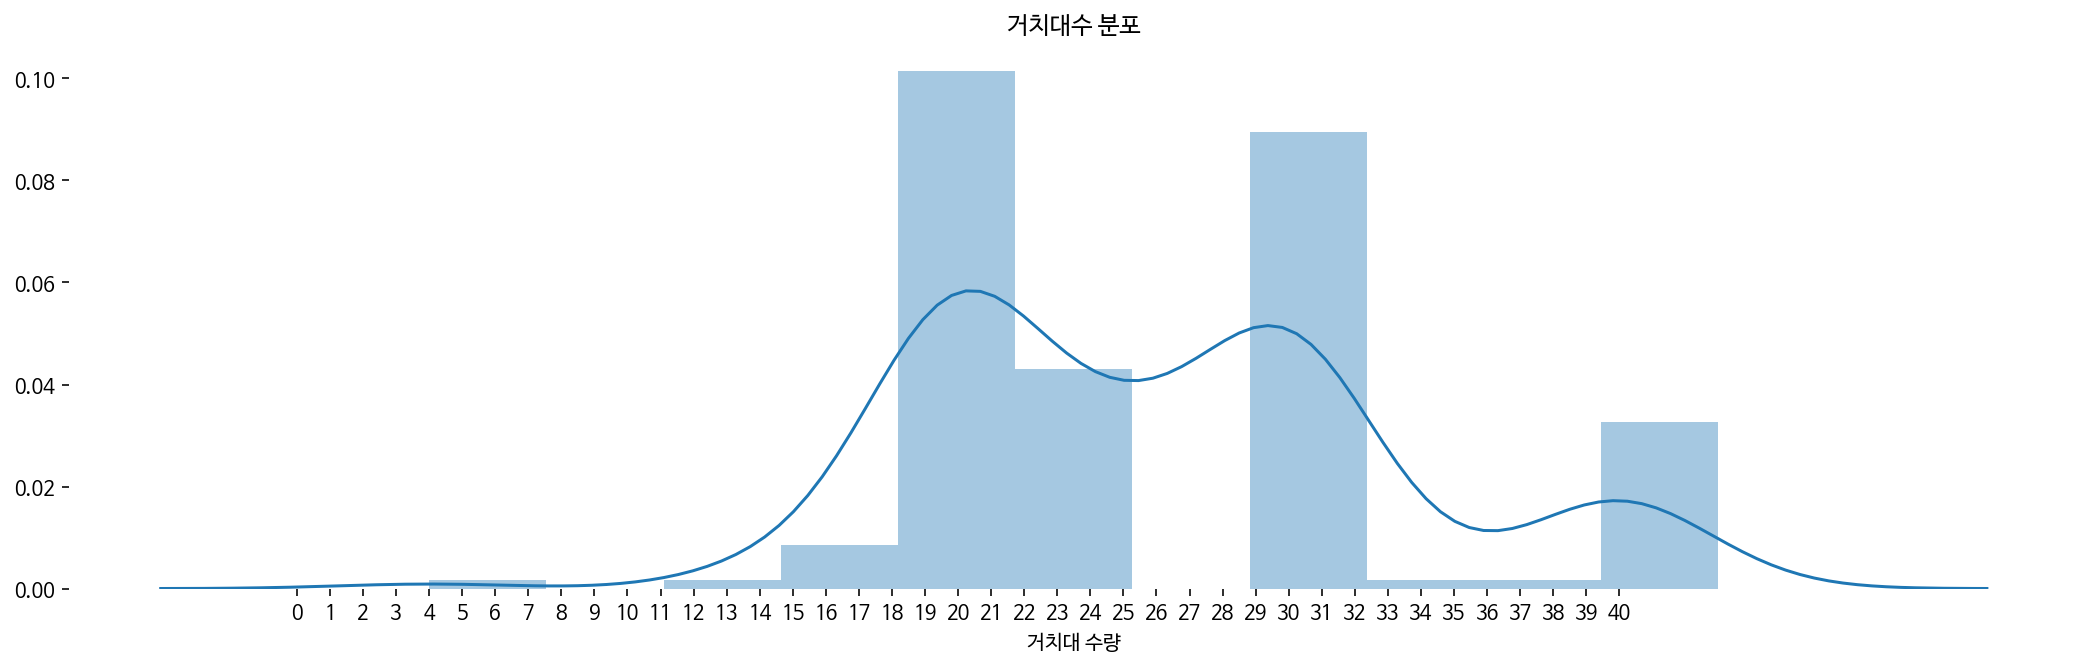

In [ ]:
plt.figure(figsize=(18, 5))
sns.distplot(station['거치대 수량'])
plt.title("거치대수 분포")
plt.xticks(range(0, 41))
plt.box(False)
plt.show()

- 약 40대의 거치대를 보유하고 있는 대형 스테이션이 다소 존재한다.
- 약 20대, 30대의 거치대를 보유하고있는 스테이션이 가장 많다.


### (4).1 동별 스테이션 별 거치대 수

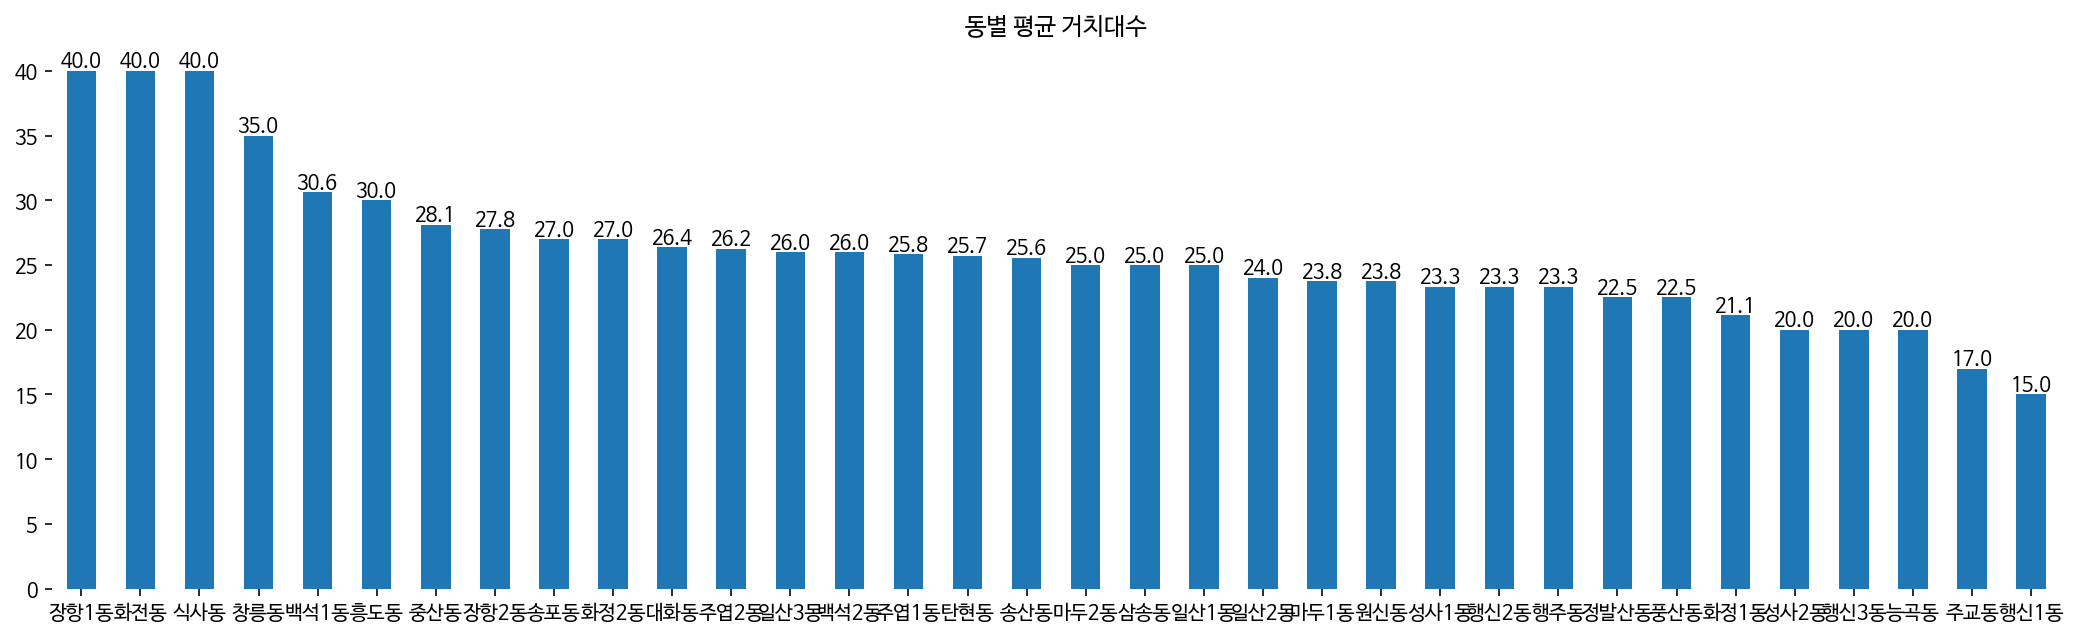

In [ ]:
bike_rental = station.groupby('dong')['거치대 수량'].sum()
bike_rental = bike_rental / dong_have_bikes
bike_rental.sort_values(ascending=False, inplace=True)

ax = bike_rental.plot(kind='bar', figsize=(18, 5), rot=0, title="동별 평균 거치대수")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%.1f"%(height), (left+width/2, height+0.3), ha='center')
plt.box(False)
plt.xlabel("")
plt.show()

- Top 3
  - 장항1동: 2개의 스테이션 보유, 호수공원의 영향이 큰 것으로 보임
  - 화전동: 5개의 스테이션 보유, 덕양구 오른편 산 아래에 위치
  - 식사동: 2개의 스테이션 보유, 거주시설이 밀집되어 있는 구역에 위치한 것으로 보임


- Tail 3
  - 행신1동: 1개의 스테이션 보유, 동 면적 또한 좁음
  - 주교동: 1개의 스테이션 보유, 밀집 두 구역 사이에 위치
  - 능곡동: 1개의 스테이션 보유, 밀집 두 구역 사이에 위치
    - 주교동과 능곡동이 나란히 두 밀집구역을 나누는 지역임을 확인했다.


In [ ]:
bike_map = folium.Map(location=[station['위도'].mean(), station['경도'].mean()], zoom_start=10.8, tiles='cartodbpositron')
folium.Choropleth(geo_data=geo_str_34,
                  data=bike_rental,
                  key_on='feature.properties.행정동명', 
                  fill_color='Blues').add_to(bike_map)
bike_map

# EDA 2

## (5) 스테이션간 평균거리

### (5).1. 구별 대여소간 평균거리

In [ ]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    m = 1000 * km
    return m

In [ ]:

dict_dists = {}
for name, df in station.groupby('gu'):
    dists = []
    for i, i_row in df.iterrows():
        min_dist = float('INF')
        
        for j, j_row in df.iterrows():
            if i == j:
                continue
            distance = haversine(i_row['경도'], i_row['위도'], j_row['경도'], j_row['위도'])       
            min_dist = distance if distance < min_dist else min_dist
        if min_dist == float('INF'):
          min_dist = 0
        dists.append(min_dist)
    dict_dists[name] = dists
#dict_dists

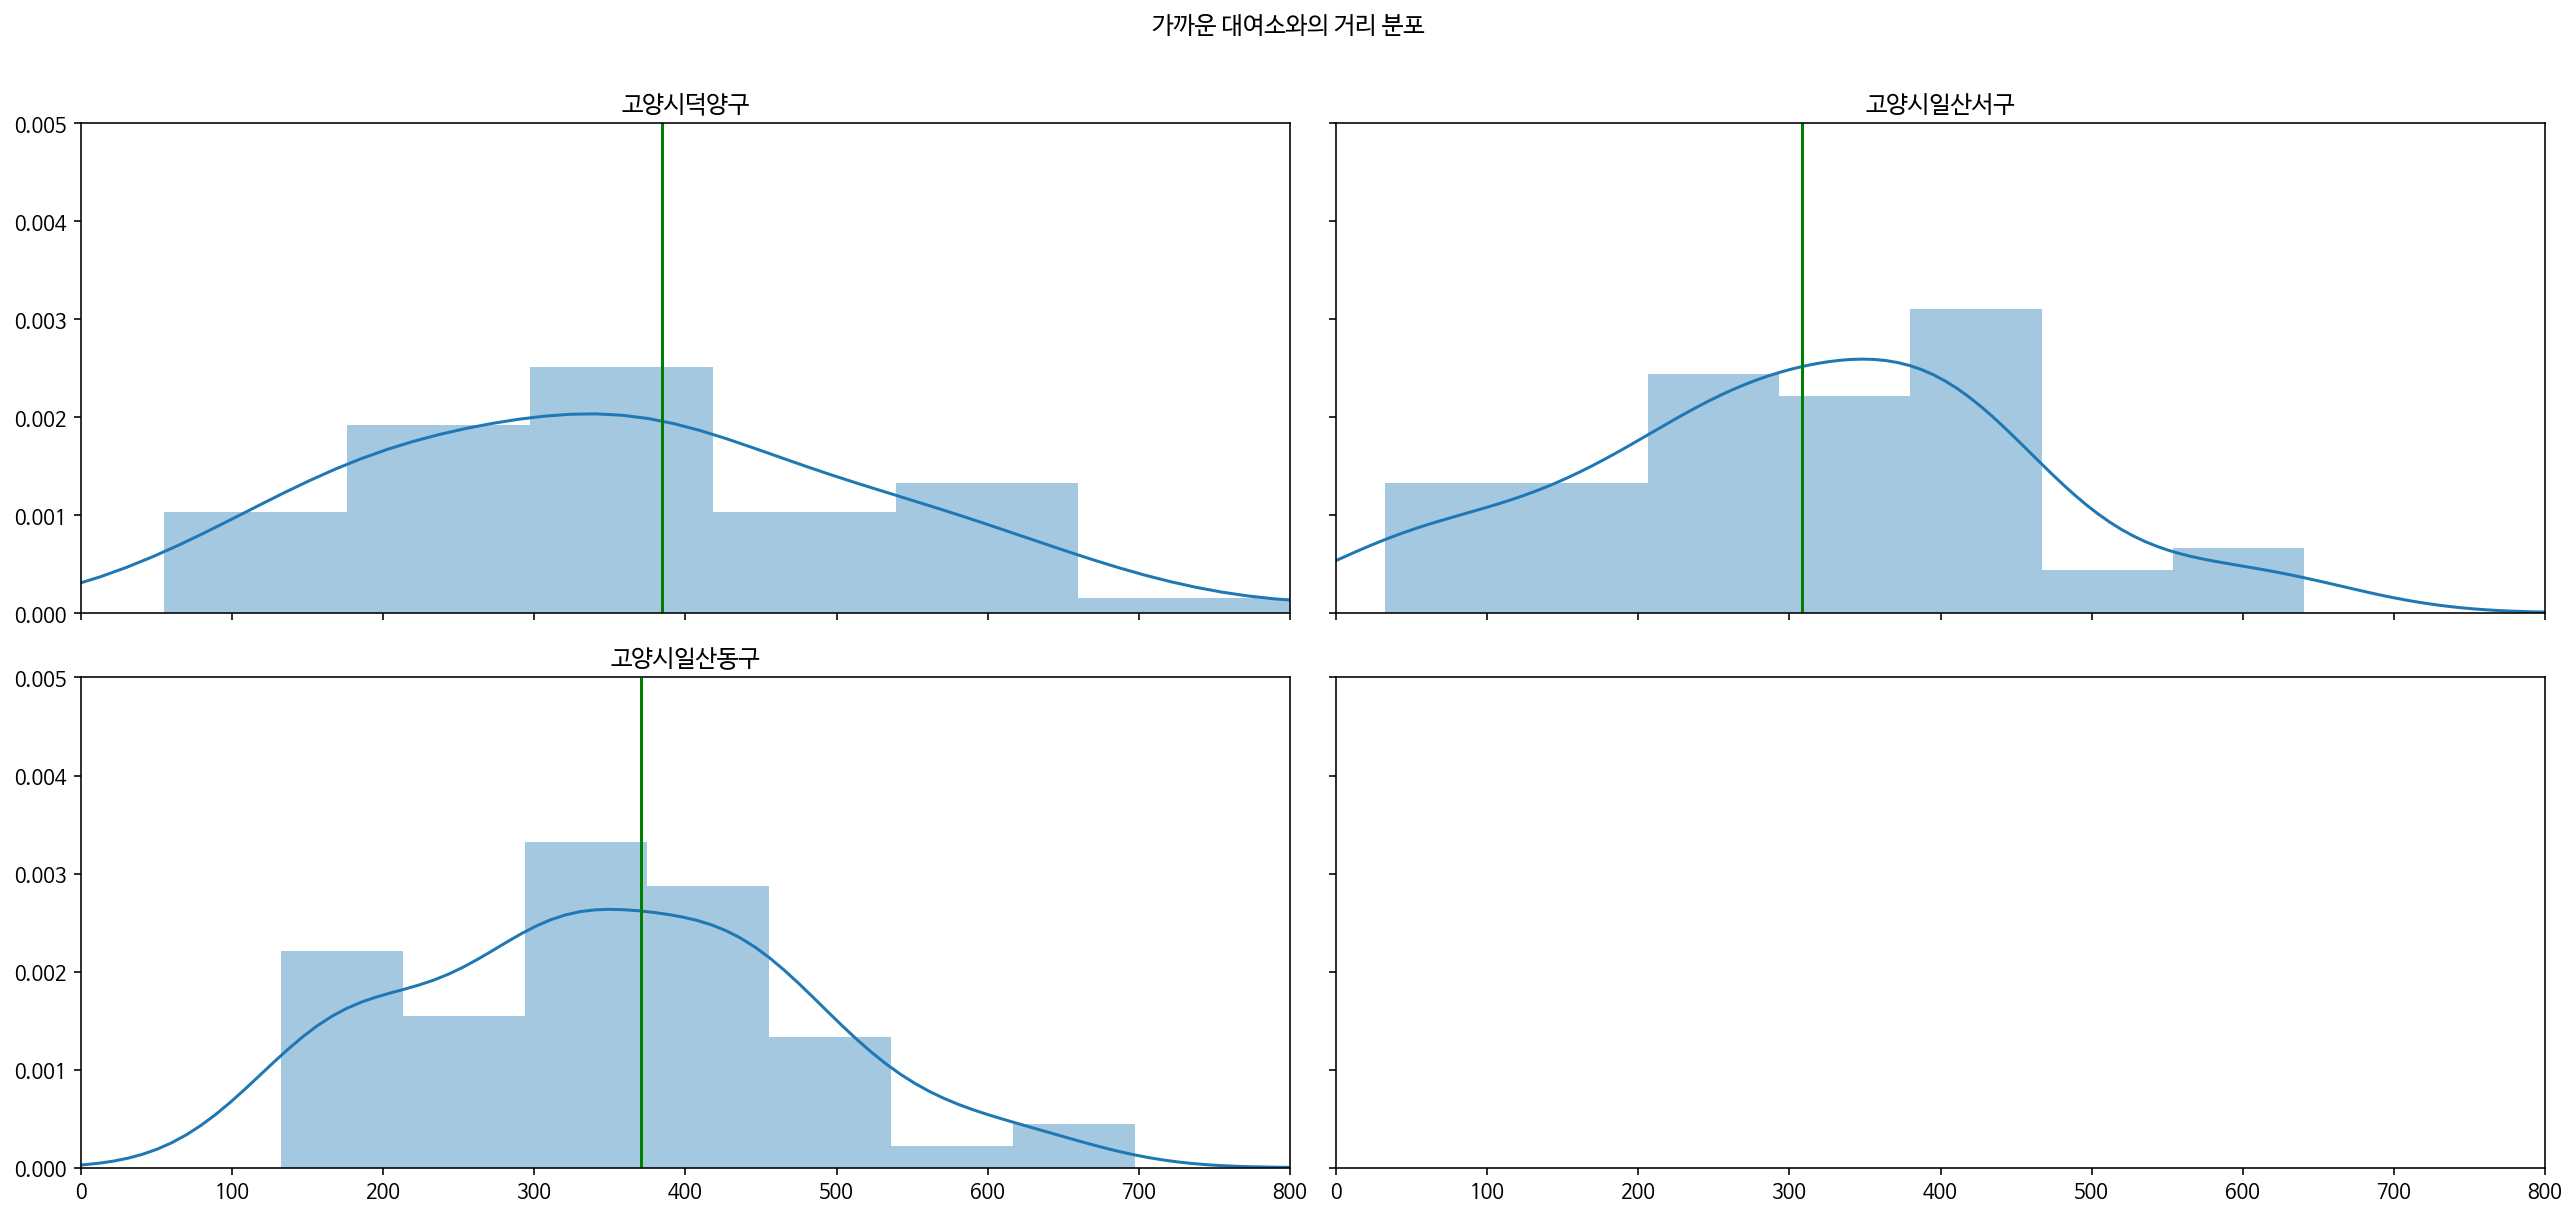

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(18, 8), sharex=True, sharey=True)

i, j = 0, 0
for name, dists in dict_dists.items():
    sns.distplot(dists, ax=axes[j][i])
    axes[j][i].set_title(name)
    axes[j][i].axvline(np.array(dists).mean(), color='green')
    j += 1
    if j >= 2:
        i += 1
        j = 0

fig.suptitle("가까운 대여소와의 거리 분포", y=1.05)
plt.xlim(0, 800)
plt.ylim(0,0.005)
fig.tight_layout()
plt.show()

- 세 구 모두 비슷한 그래프 형태가 나타난다.
  - 평균 스테이션간 거리가 모두 300m ~ 400m 구간에 있다.
  >

- 일산서구는 스테이션간 평균거리가 더 가까운 것으로 나타난다.
- 덕양구는 스테이션간 거리가 긴 구간이 다른 구보다 많이 나타난다.

### (5).2. 동별 대여소간 평균거리

In [ ]:

dict_dists = {}
for name, df in station.groupby('dong'):
    dists = []
    for i, i_row in df.iterrows():
        min_dist = float('INF')
        
        for j, j_row in df.iterrows():
            if i == j:
                continue
            distance = haversine(i_row['경도'], i_row['위도'], j_row['경도'], j_row['위도'])       
            min_dist = distance if distance < min_dist else min_dist
        if min_dist == float('INF'):
          min_dist = 0
        dists.append(min_dist)
    dict_dists[name] = dists
#dict_dists

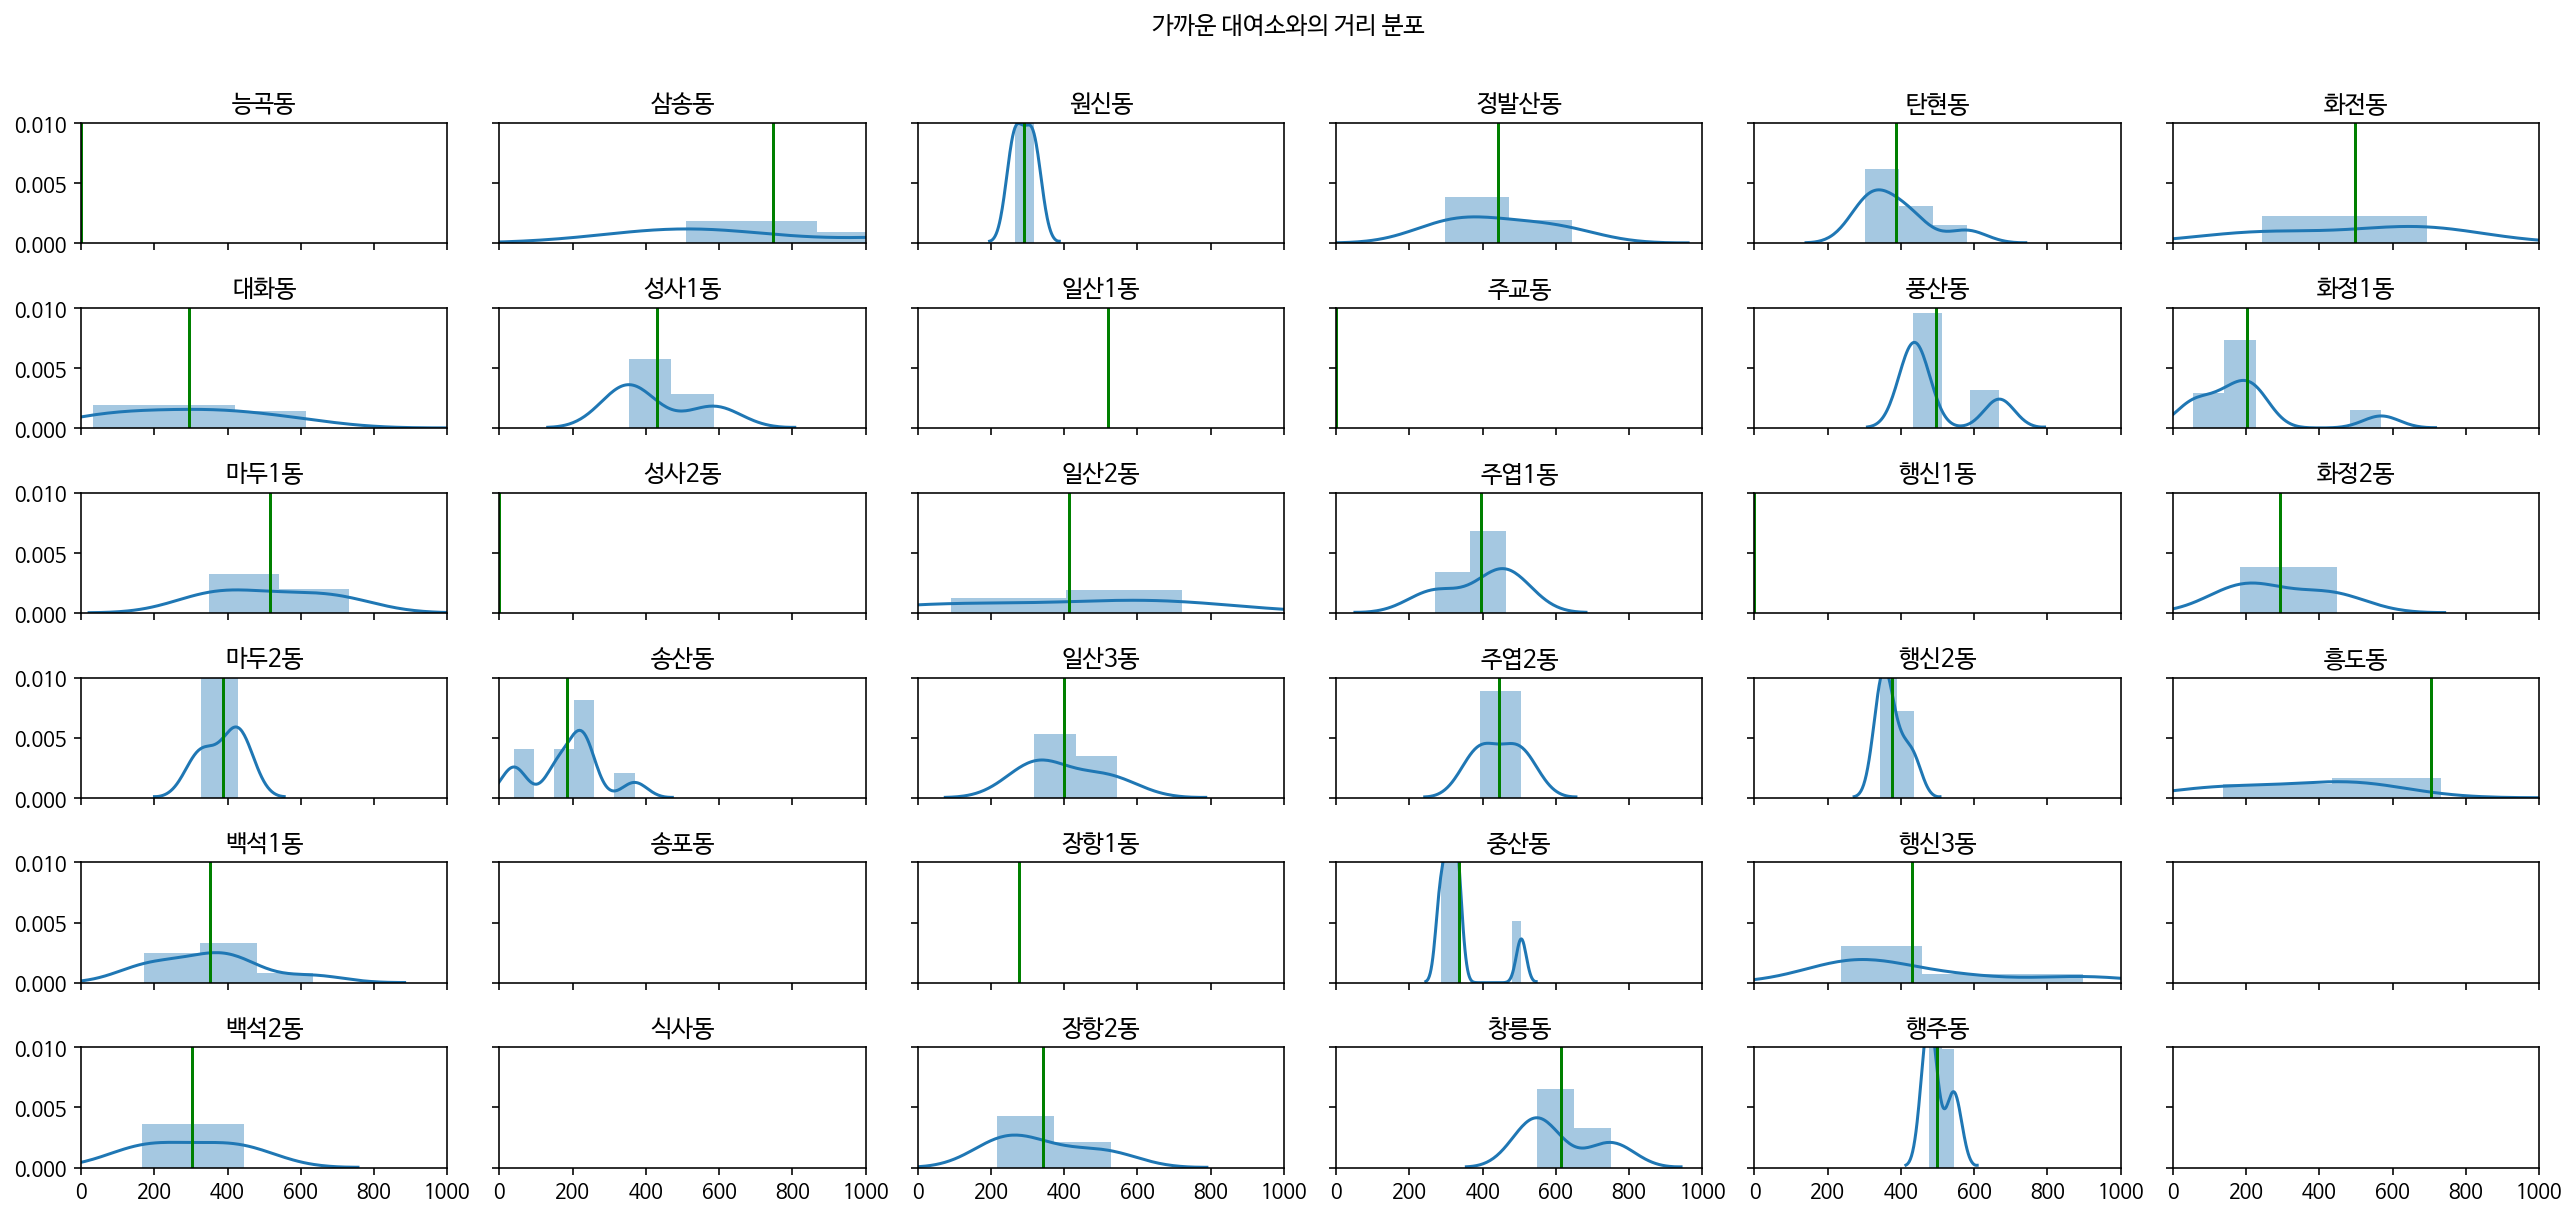

In [ ]:
fig, axes = plt.subplots(6,6, figsize=(18, 8), sharex=True, sharey=True)

i, j = 0, 0
for name, dists in dict_dists.items():
    sns.distplot(dists, ax=axes[j][i])
    axes[j][i].set_title(name)
    axes[j][i].axvline(np.array(dists).mean(), color='green')
    j += 1
    if j >= 6:
        i += 1
        j = 0

fig.suptitle("가까운 대여소와의 거리 분포", y=1.05)
plt.xlim(0, 1000)
plt.ylim(0,0.01)
fig.tight_layout()
plt.show()

- 위의 그래프는 사실상 큰 의미가 없다고 판단된다.
- 왜냐하면 동마다 면적이 다르고 설치되어있는 스테이션 수가 상이하기 때문이다.

In [ ]:
# # fig, axes = plt.subplots(6,6, figsize=(18, 8), sharex=True, sharey=True)

# # i, j = 0, 0
# for name, dists in dict_dists.items():
#     # sns.distplot(dists, ax=axes[j][i])
#     # axes[j][i].set_title(name)
#     # axes[j][i].axvline(np.array(dists).mean(), color='green')
#     print(np.array(dists).mean())

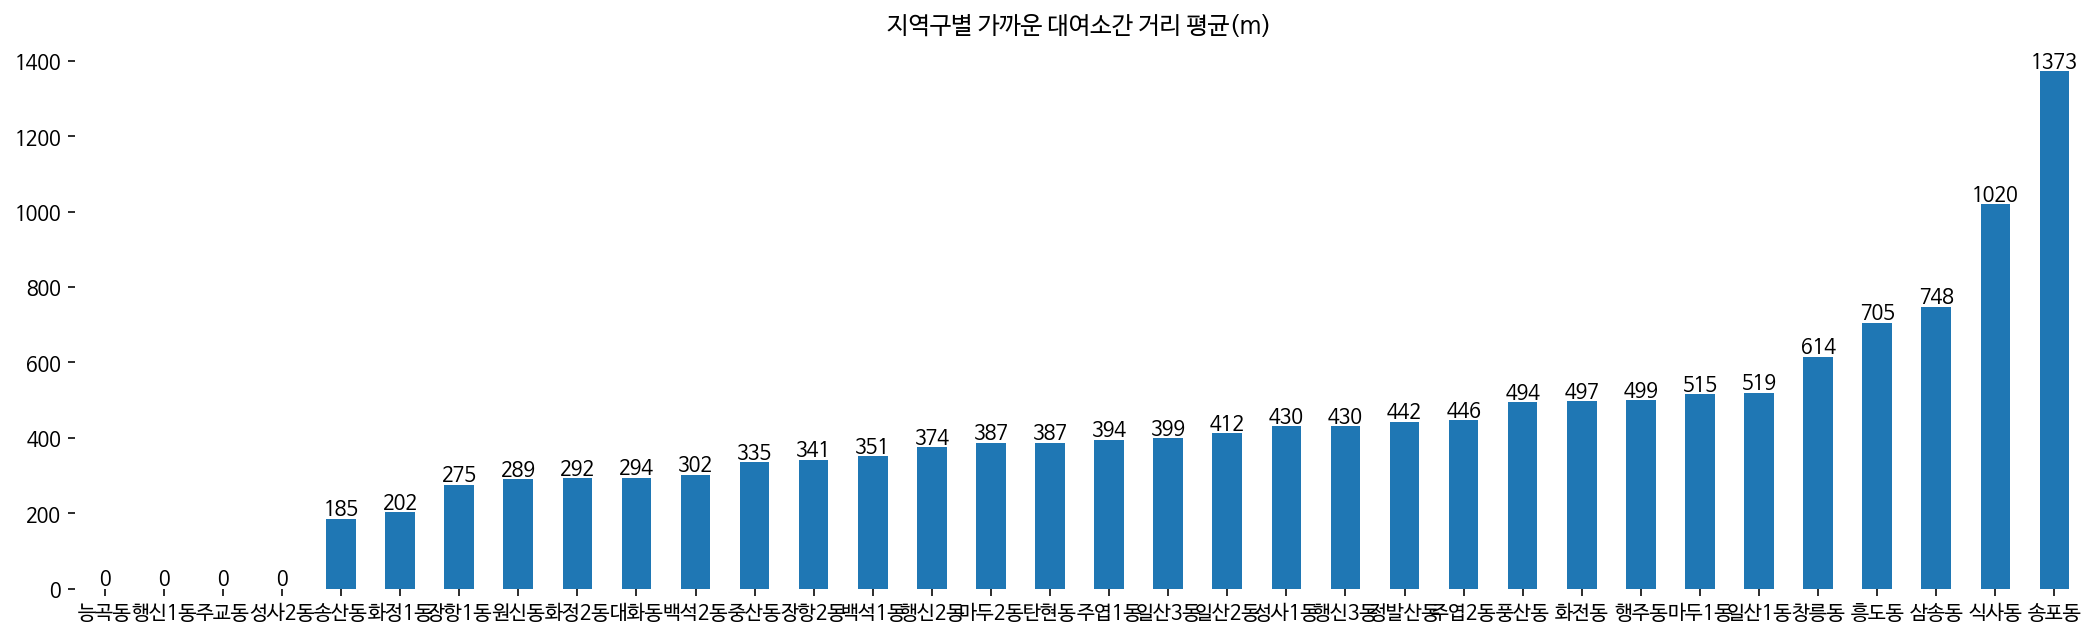

In [ ]:

dist_means = {name: np.mean(dists) for name, dists in dict_dists.items() }
dist_means = pd.Series(dist_means)
dist_means.sort_values(inplace=True)

ax = dist_means.plot(kind='bar', figsize=(18, 5), rot=0, legend=False, title="지역구별 가까운 대여소간 거리 평균(m)")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%d"%(height), (left+width/2, height+10), ha='center')
plt.box(False)
plt.show()

- 0m 로 표시되는 값은 해당 지역 내에 스테이션의 개수가 1개인 지역이다.
- 송포동의 경우 1373m로 이상치 값을 보여준다.
  - 확인한 결과 송포동의 지역내에 2개의 스테이션만 존재하며 그 스테이션간의 거리가 먼 것으로 확인하였다.


In [ ]:
# 거리가 멀수록 진한 색
bike_map = folium.Map(location=[station['위도'].mean(), station['경도'].mean()], zoom_start=10.8, tiles='cartodbpositron')
folium.Choropleth(geo_data=geo_str_34,
                  data=dist_means,
                  key_on='feature.properties.행정동명', 
                  fill_color='Blues').add_to(bike_map)
bike_map

- 색이 옅을 수록 평균거리가 짧다.


## (6) 피프틴 사용량

### (6).1 데이터 전처리

In [ ]:
# 사용할 데이터셋 불러오기
df_1=pd.read_csv('/content/gdrive/My Drive/고양시피프틴/01.운영이력.csv')

- 데이터 정의서
  + LEAS_NO : 대여번호
  + LEAS_DATE : 대여 시간
  + LEAS_STATION : 대여 스테이션 번호
  + LEAS_DEF_NO : 대여 거치대 번호
  + RTN_DATE : 반납 시간
  + RTN_STATION : 반납 스테이션 번호
  + RTN_DEF_NO : 반납 거치대 번호
  + RTN_PROCESS : 관제반납구분값
    + (01: 관제반납 / 02: 관리자반납 / 03: 관리자반출 / 04: 타 사용자 반납 / 05: 다른 사용자 반출)
  + TRNV_QTY : 추정 이동 거리(m)
  + MEMB_DIV : 회원 구분(비회원은 99이며 나머지는 정회원)
  + MEMB_NO : 회원 번호
  + TEMP_MEMB_NO : 비회원 번호
  + BIKE_TAG : 자전거 번호

In [ ]:
df_1.head()

LEAS_NO  LEAS_STAT  ...        BIKE_TAG  RTN_PROCESS
0  15945541          2  ...  1A844000000BB7          NaN
1  15945542          2  ...  1A844000000494          NaN
2  15945543          2  ...  1A844000000533          1.0
3  15945544          2  ...  1A844000000731          NaN
4  15945545          2  ...  1A84400000F343          NaN

[5 rows x 14 columns]

- 데이터 결측치 확인

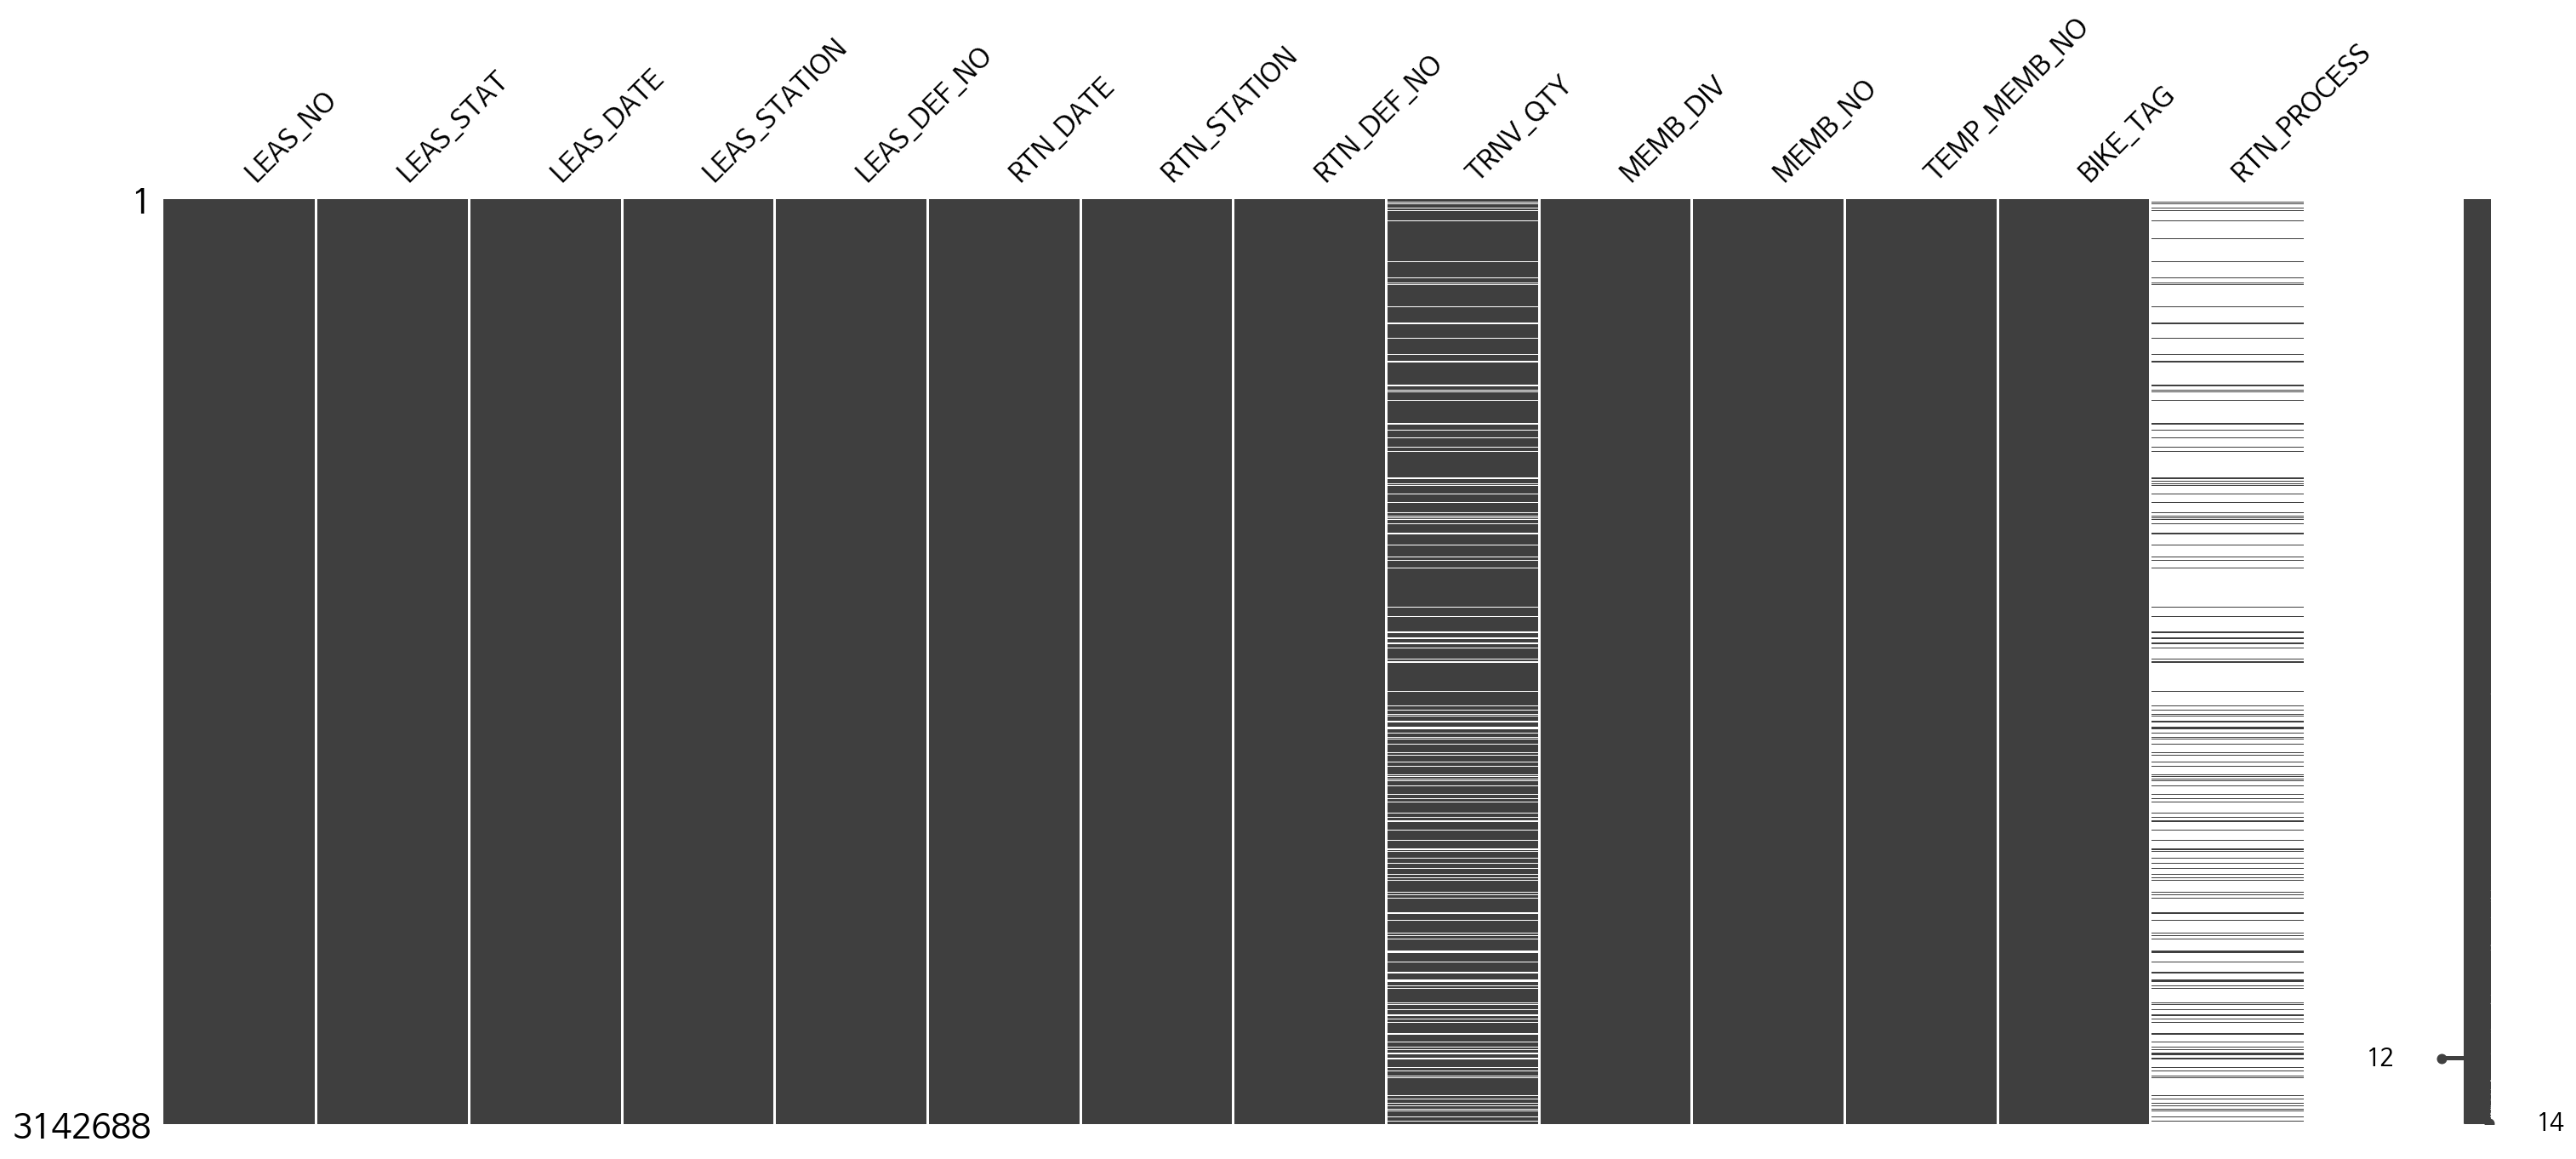

In [ ]:
msno.matrix(df_1)
plt.show()

- TRNV_QTY(추정 이동 거리) 값과 RTN_PROCESS(관제반납구분) 값의 데이터에 결측치가 상당수 존재하는 것을 확인할 수 있다. 

- 대여 일시와 반납 일시로부터 월별 데이터를 추출한다.

In [ ]:
#대여 일시를 월별로 분류
df_1['LEAS_MONTH_ONLY']= df_1['LEAS_DATE'].map(lambda x: x.split(' ')[0][:-3])

#반납 일시를 월별로 분류
df_1['RTN_MONTH_ONLY']= df_1['RTN_DATE'].map(lambda x: x.split(' ')[0][:-3])
df_1.head()

LEAS_NO  LEAS_STAT  ... LEAS_MONTH_ONLY  RTN_MONTH_ONLY
0  15945541          2  ...         2017-01         2017-01
1  15945542          2  ...         2017-01         2017-01
2  15945543          2  ...         2017-01         2017-01
3  15945544          2  ...         2017-01         2017-01
4  15945545          2  ...         2017-01         2017-01

[5 rows x 16 columns]

- LEAS_STATION, RTN_STATION 데이터 중 '0, 999, 998, 992'는 제외하도록 한다.
  - 제외하는 이유는 다음과 같다.
    - 수리로 인해 스테이션 반납이 아닌 관제 센터로 반납된 경우
    - 분실로 인해 반납이 이뤄지지 않은 경우
    - 내부 테스트를 위해 가상으로 등록된 데이터인 경우

In [ ]:
# 반납 스테이션 0, 999, 998 제외
case = df_1['RTN_STATION'].isin([0, 999, 998, 992])
df_1_copy=df_1[~case]
df_1_copy.head()

LEAS_NO  LEAS_STAT  ... LEAS_MONTH_ONLY  RTN_MONTH_ONLY
0  15945541          2  ...         2017-01         2017-01
1  15945542          2  ...         2017-01         2017-01
3  15945544          2  ...         2017-01         2017-01
4  15945545          2  ...         2017-01         2017-01
5  15945546          2  ...         2017-01         2017-01

[5 rows x 16 columns]

- 대여(스테이션, 월별) 횟수를 확인한다.

In [ ]:
leas_count=df_1_copy.groupby(['LEAS_STATION', 'LEAS_MONTH_ONLY']).count().max(axis=1).reset_index()
leas_count.columns=['Station_ID','DATE','LEAS_COUNT']
leas_count

Station_ID     DATE  LEAS_COUNT
0            101  2017-01          73
1            101  2017-02          68
2            101  2017-03         186
3            101  2017-04         282
4            101  2017-05         385
...          ...      ...         ...
5379         992  2019-08          34
5380         992  2019-09          27
5381         992  2019-10          12
5382         992  2019-11          21
5383         992  2019-12          15

[5384 rows x 3 columns]

- 반납(스테이션, 월별) 횟수를 확인한다.

In [ ]:
rtn_count=df_1_copy.groupby(['RTN_STATION', 'RTN_MONTH_ONLY']).count().max(axis=1).reset_index()
rtn_count.columns=['Station_ID','DATE','RTN_COUNT']
rtn_count

Station_ID     DATE  RTN_COUNT
0            101  2017-01        109
1            101  2017-02         89
2            101  2017-03        204
3            101  2017-04        372
4            101  2017-05        500
...          ...      ...        ...
5348         350  2019-12         37
5349         351  2019-09          5
5350         351  2019-10        112
5351         351  2019-11        140
5352         351  2019-12        149

[5353 rows x 3 columns]

- 하나의 데이터프레임으로 묶어주도록 한다.

In [ ]:
station_leas_rtn=pd.merge(leas_count,station[['Station_ID','gu','dong','STATION_NAME']],on='Station_ID',how='left')
station_leas_rtn=pd.merge(station_leas_rtn,rtn_count,on=['Station_ID','DATE'],how='left')

- 칼럼을 정리한다.

In [ ]:
station_leas_rtn=station_leas_rtn[['gu','dong','Station_ID','DATE','LEAS_COUNT','RTN_COUNT']]
station_leas_rtn

gu  dong Station_ID     DATE  LEAS_COUNT  RTN_COUNT
0     고양시덕양구  성사2동        101  2017-01          73      109.0
1     고양시덕양구  성사2동        101  2017-02          68       89.0
2     고양시덕양구  성사2동        101  2017-03         186      204.0
3     고양시덕양구  성사2동        101  2017-04         282      372.0
4     고양시덕양구  성사2동        101  2017-05         385      500.0
...      ...   ...        ...      ...         ...        ...
5379  고양시덕양구  화정1동        992  2019-08          34        NaN
5380  고양시덕양구  화정1동        992  2019-09          27        NaN
5381  고양시덕양구  화정1동        992  2019-10          12        NaN
5382  고양시덕양구  화정1동        992  2019-11          21        NaN
5383  고양시덕양구  화정1동        992  2019-12          15        NaN

[5384 rows x 6 columns]

- 결측치는 0으로 대체한다.

In [ ]:
station_leas_rtn=station_leas_rtn.fillna(0)

### (6).2 월별 사용량

- 만들어진 데이터 셋을 가지고 사용량을 시각화한다.

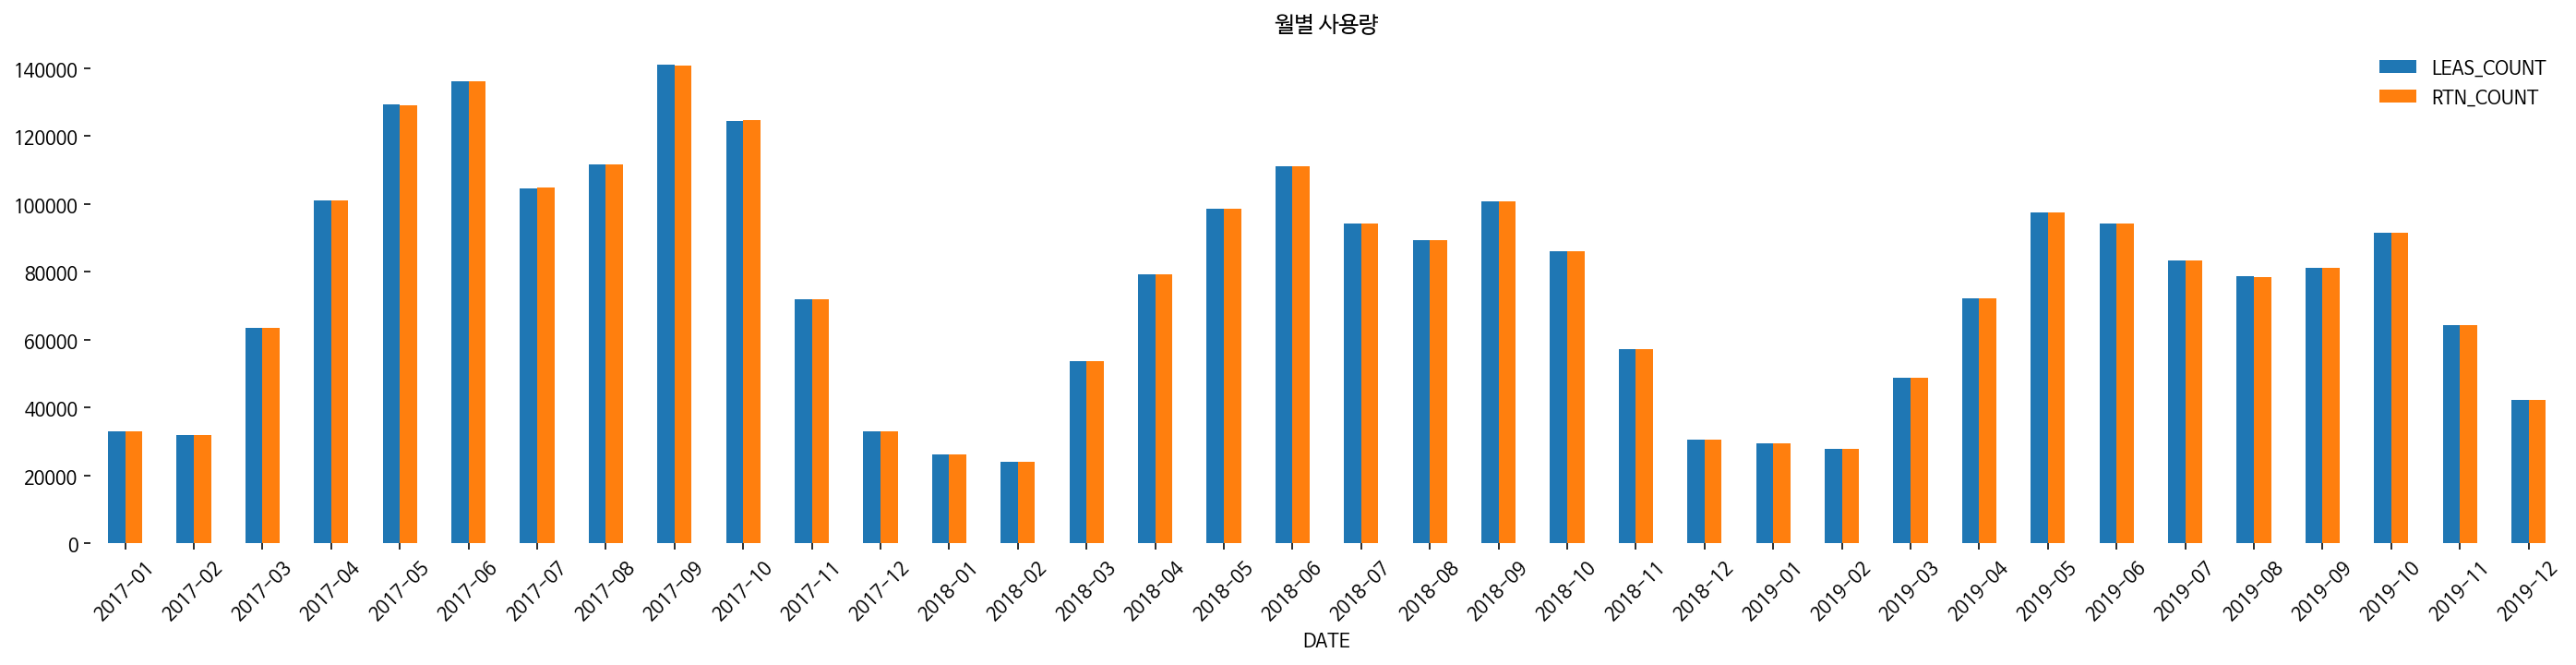

In [ ]:
month = station_leas_rtn.groupby(['DATE'])[['LEAS_COUNT', 'RTN_COUNT']].sum()
month.plot(kind='bar', figsize=(24, 5), rot=45, title="월별 사용량")
plt.box(False)
plt.legend(frameon=False)
plt.show()

- 평균적으로 한 해 중 날씨가 좋은 5월, 6월, 9월, 10월에 사용량이 가장많았다.
- 겨울과 여름에는 사용량이 줄어드는 것을 알 수 있다.
- 하지만 해가 지날수록 사용량은 점점 떨어지고있다.

### (6).3 동별 사용량

In [ ]:
sum_of_use = station_leas_rtn.groupby('dong')[['LEAS_COUNT', 'RTN_COUNT']].sum()
sum_of_use.head()

LEAS_COUNT  RTN_COUNT
dong                       
능곡동         5586     6163.0
대화동       201177   189596.0
마두1동      200760   188514.0
마두2동      177077   166293.0
백석1동      132034   128931.0

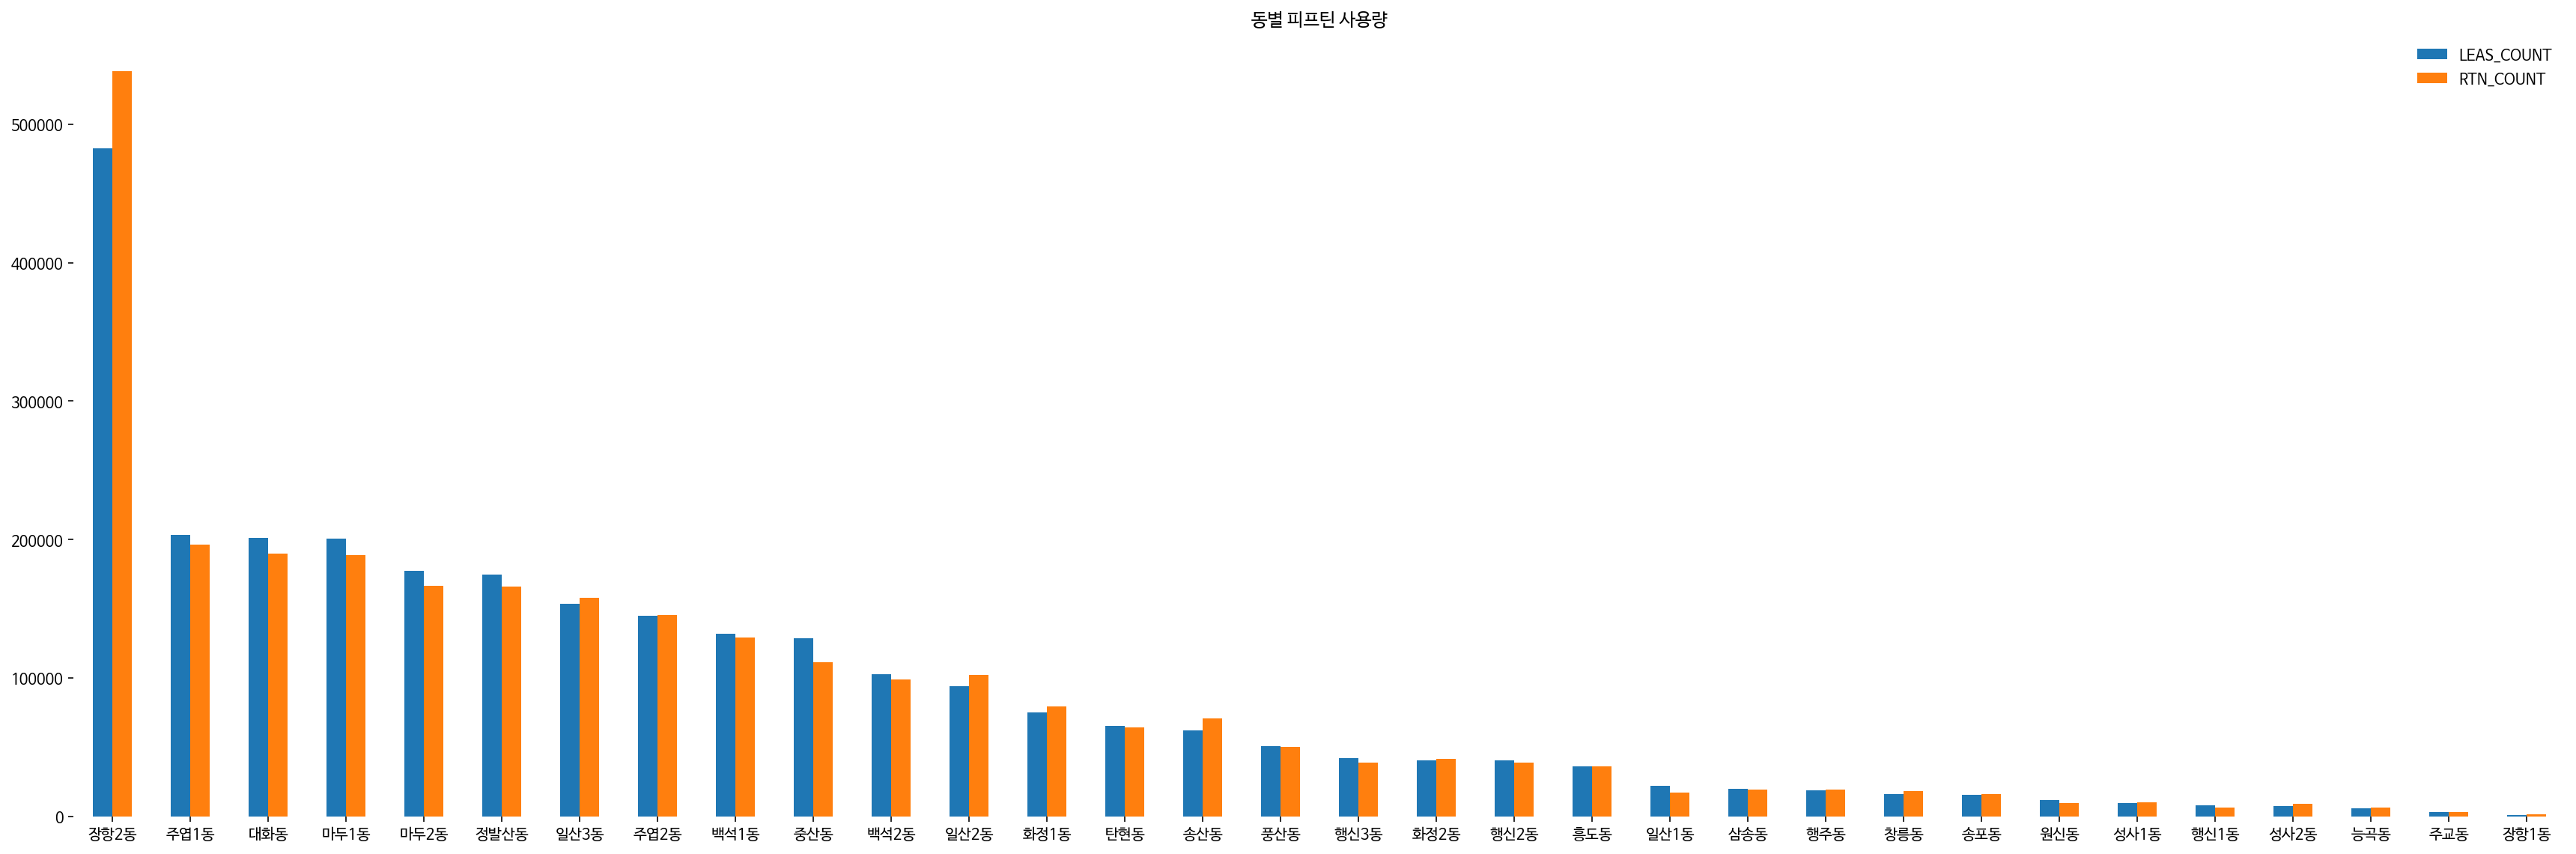

In [ ]:
sum_of_use.sort_values('LEAS_COUNT', ascending=False, inplace=True)
sum_of_use.plot(kind='bar', figsize=(24, 8), title="동별 피프틴 사용량", rot=0)
plt.xlabel("")
plt.box(False)
plt.tight_layout()
plt.legend(frameon=False)
plt.show()

- 대여량과 반납량이 상이하다.
  - 사용자들의 대여, 반납 스테이션이 같지 않다는 것을 알 수 있다.
- 장향2동의 사용량이 압도적으로 높다.
  - 호수공원과 근접해 있기에 많은 사용자들이 몰린다고 추측해 볼 수 있다.

- 대여량 최하위를 기록하는 장향1동(833)과 최상위를 기록하는 장향2동(482,396)간에는 약 580배 차이를 기록한다.

### (6).4 동별 대여량 (히트맵)
- 시각화에 앞서 '장항2동'의 데이터는 제외하고 진행하도록 한다.
  + 앞도적인 데이터량으로 인해 타 범주간 비교가 미미해지기 때문이다.

In [ ]:
pvt_num_use = station_leas_rtn.pivot_table(index=['dong'], columns=['DATE'], values='LEAS_COUNT', aggfunc='sum').fillna(0)
pvt_num_use = pvt_num_use.astype('int')
#pvt_num_use = pvt_num_use.reindex(index=region_index)
pvt_num_use_copy=pvt_num_use.drop(['장항2동'])
pvt_num_use_copy

DATE  2017-01  2017-02  2017-03  2017-04  ...  2019-09  2019-10  2019-11  2019-12
dong                                      ...                                    
능곡동        38       67      102      188  ...      269      280      141       44
대화동      2675     2484     4842     7503  ...     5348     5922     4263     3056
마두1동     2375     2241     4776     6855  ...     5529     6707     4795     3216
마두2동     2555     2260     4230     6335  ...     4718     5360     4049     2733
백석1동     1530     1401     2547     3927  ...     4174     4793     3164     1760
백석2동     1131      987     2009     3521  ...     3178     3656     2150     1346
삼송동       162      169      354      595  ...      594      715      489      302
성사1동      108      123      254      402  ...      298      346      182      156
성사2동       73       68      186      282  ...      233      271      143       91
송산동       771      790     1492     2489  ...     1960     2218     1418      881
송포동       161      118      355      580  ...      453      462      498      513
원신동       118       81      202      383  ...      313      355      217      165
일산1동      388      405      669      828  ...      562      551      418      277
일산2동     1192     1130     2152     3257  ...     2611     3081     2286     1540
일산3동     1819     1654     3274     5082  ...     4814     5551     4265     2747
장항1동        0        0        0        0  ...        0       84      379      370
정발산동     2565     2483     4405     5896  ...     4463     5576     4419     3196
주교동        44       60       68      161  ...      127      124       49       37
주엽1동     2500     2359     4713     7357  ...     5753     7002     5200     3632
주엽2동     2001     1916     3523     5049  ...     3849     4486     3529     2264
중산동      1641     1887     3105     4423  ...     4223     4801     3708     2648
창릉동        61       41      113      312  ...      568      668      342      248
탄현동       865      801     1467     2212  ...     1948     2290     1549     1202
풍산동       527      541     1103     1626  ...     1573     1790     1240      857
행신1동       82       73      161      252  ...      246      281      236      151
행신2동      437      459      784     1281  ...     1601     1532      991      582
행신3동      507      331      818     1308  ...     1478     1429      892      581
행주동       261      233      477      708  ...      656      651      552      310
화정1동      757      697     1613     2884  ...     2258     2429     1548     1034
화정2동      431      417      969     1561  ...     1218     1353      826      477
흥도동       356      475      736     1123  ...     1289     1375      999      615

[31 rows x 36 columns]

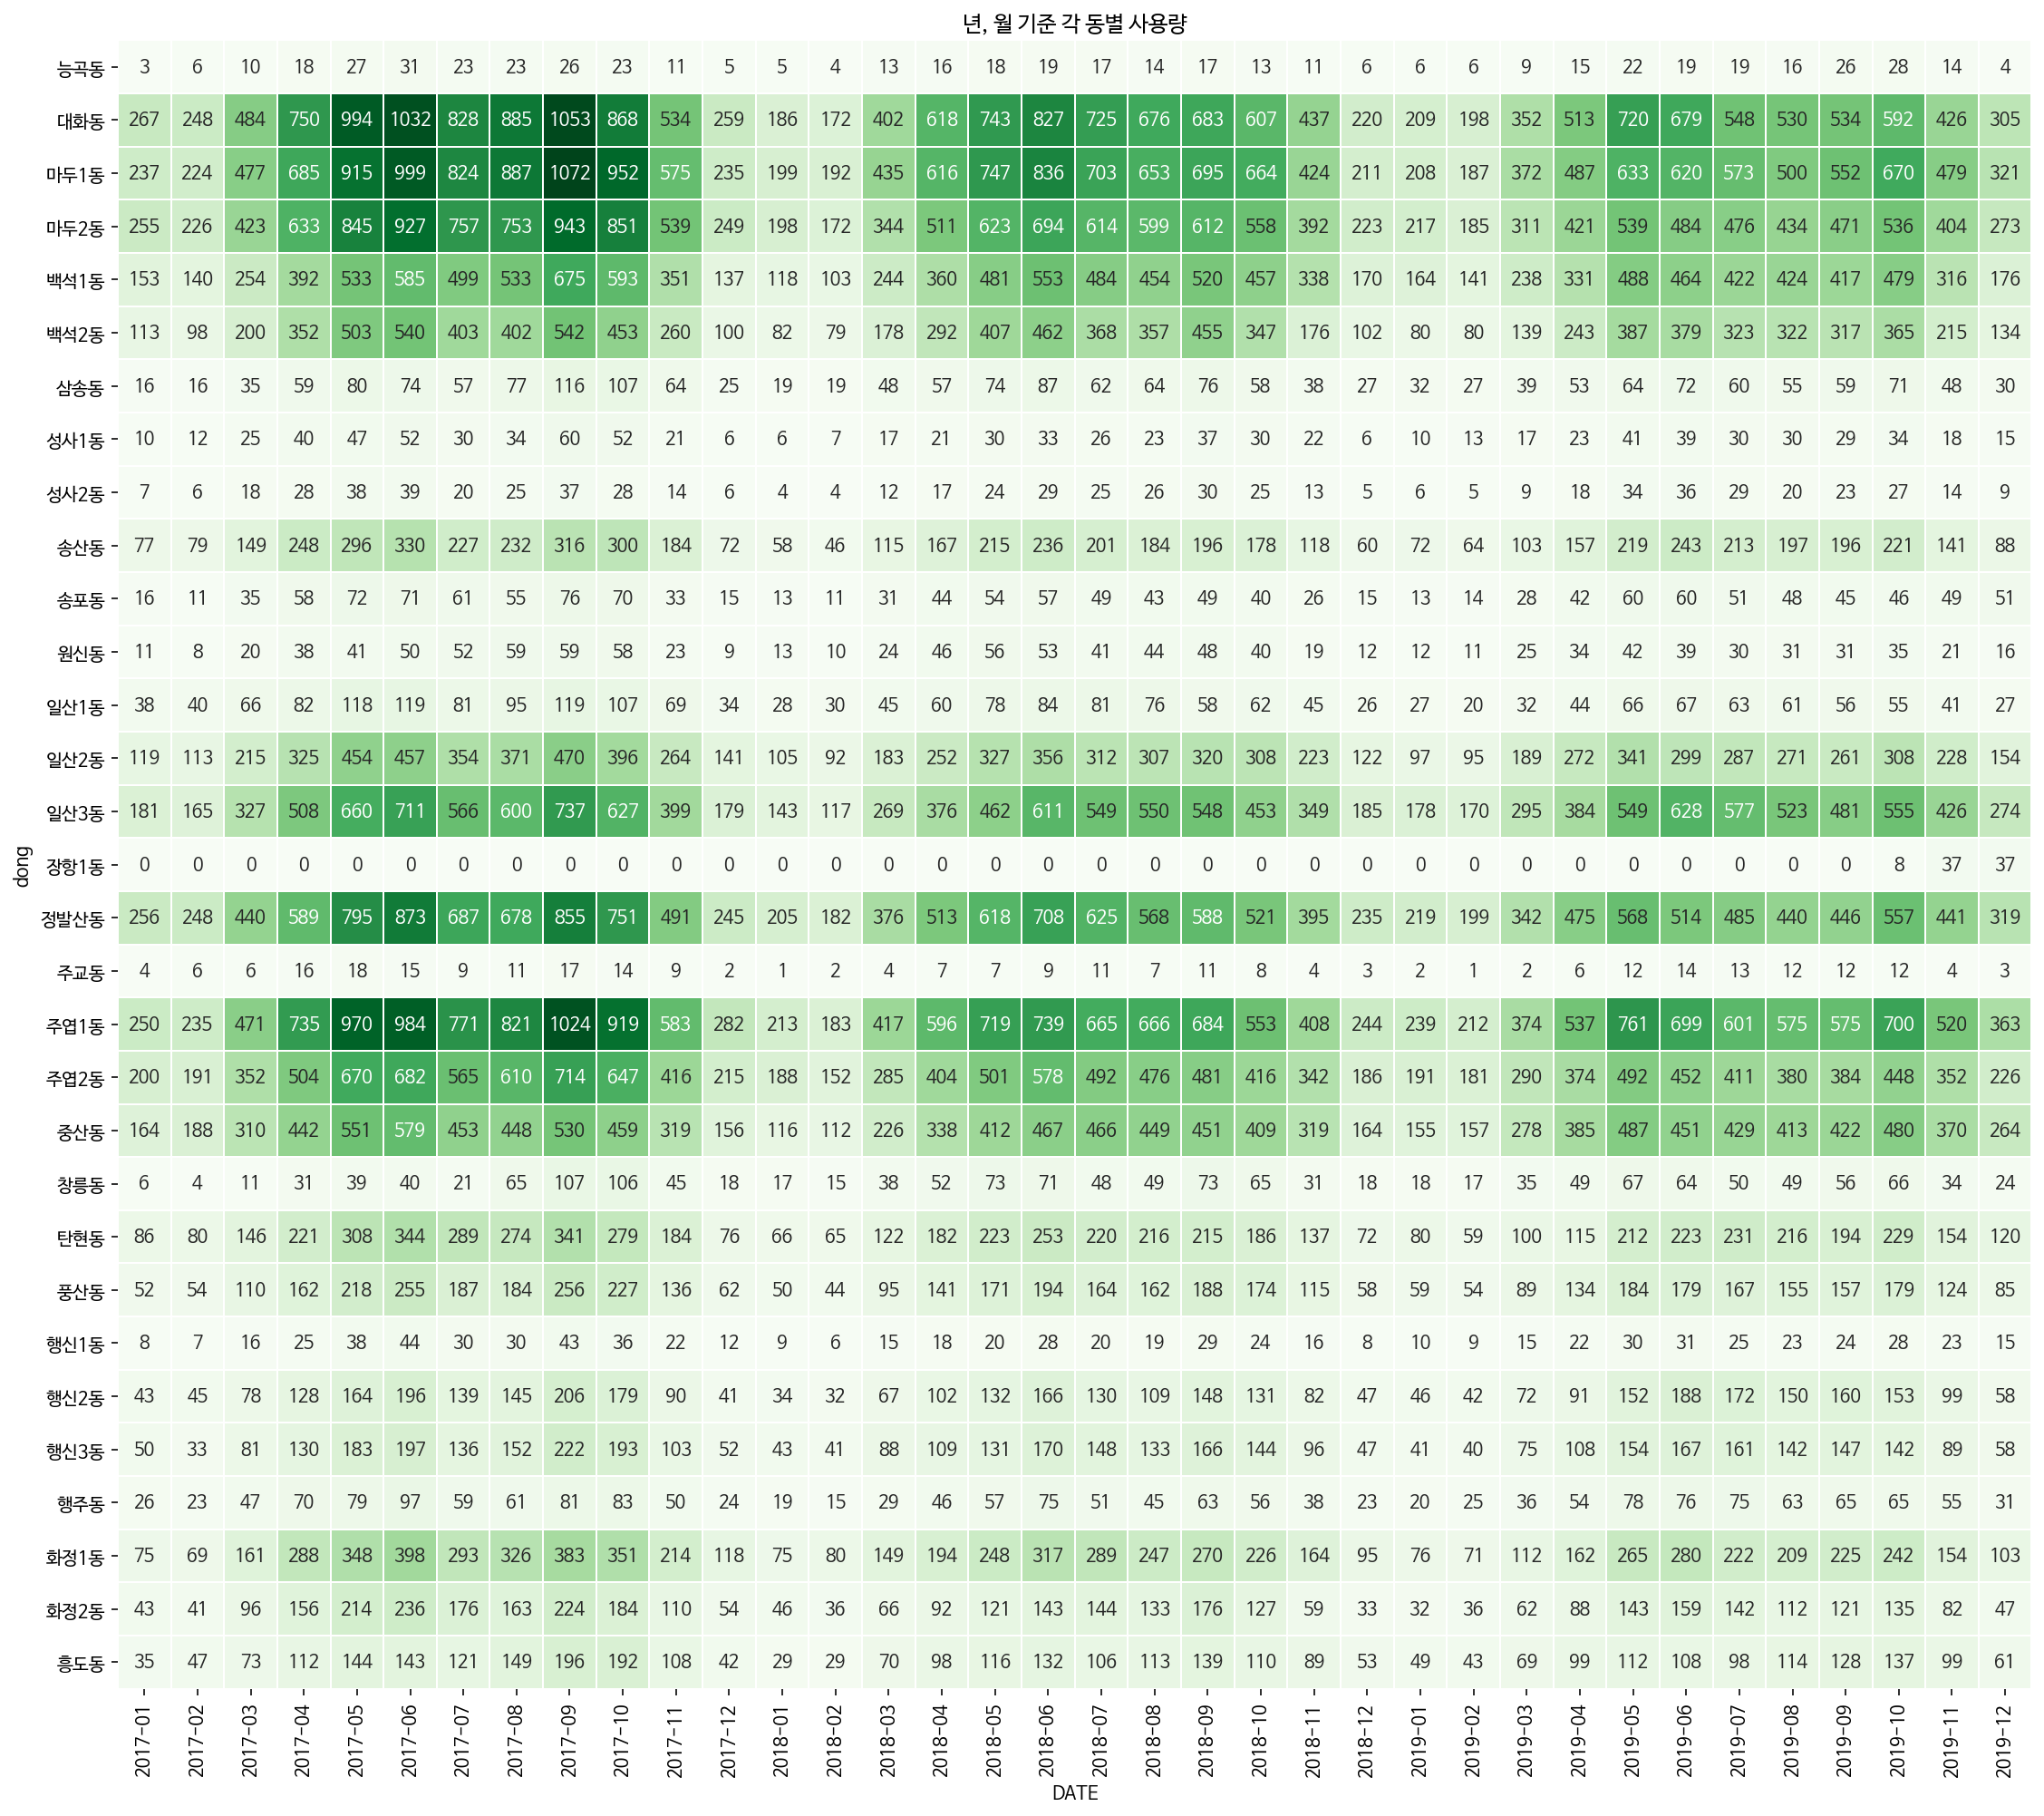

In [ ]:
unit = 10

plt.figure(figsize=(24, 14))
sns.heatmap((pvt_num_use_copy/unit).astype('int'), square=True, cmap='Greens', linewidth=0.5, cbar=False, annot=True, fmt='d')
plt.title("년, 월 기준 각 동별 사용량")
plt.tight_layout()
plt.show()

- 위의 히트맵(동-연월별 대여량)을 통해 사용이 활발한 스테이션을 파악할 수 있다.
- 반납량에 대한 그래프는 대여량 수준과 비슷하므로 넘어가도록 하겠다.
- 가장 사용량이 두드러지게 나타나는 지역은 **대화동, 마두1동, 마두2동, 주엽 1동**이다.

### (6).5 동별 스테이션당 평균 이용량 (히트맵)
- 공정한 비교를 위해, 동별 대여소 개수까지 고려한, 동별 스테이션 1개당 평균 이용량을 확인해보고자 한다.
- 동별 스테이션 평균 이용량 = 동별 대여건수의 합 / 동의 스테이션 개수로 정의된다.
  + 즉, 한 스테이션당, 평균 이용량을 동별로 살펴보고자 한다.

- 스테이션의 개수 값을 가진 같은 크기의 DataFrame을 만들어준다.

In [ ]:
pvt_num_rental = station_leas_rtn.pivot_table(index=['dong'], columns=['DATE'], values='Station_ID', aggfunc='nunique').fillna(0)
pvt_num_rental.head()

DATE  2017-01  2017-02  2017-03  2017-04  ...  2019-09  2019-10  2019-11  2019-12
dong                                      ...                                    
능곡동       1.0      1.0      1.0      1.0  ...      1.0      1.0      1.0      1.0
대화동       9.0      9.0      9.0      9.0  ...      9.0      9.0      9.0      9.0
마두1동      8.0      8.0      8.0      8.0  ...      8.0      8.0      8.0      8.0
마두2동      5.0      5.0      5.0      5.0  ...      5.0      5.0      5.0      5.0
백석1동      8.0      8.0      7.0      7.0  ...      8.0      8.0      8.0      8.0

[5 rows x 36 columns]

- `pvt_num_use_copy` / `pvt_num_rental`가 바로 동별 한 개 스테이션의 평균 이용량이 나온다.

In [ ]:
pvt_use_ratio = (pvt_num_use_copy / pvt_num_rental).fillna(0)
pvt_use_ratio = pvt_use_ratio.astype('int')
pvt_use_ratio.head()

DATE  2017-01  2017-02  2017-03  2017-04  ...  2019-09  2019-10  2019-11  2019-12
dong                                      ...                                    
능곡동        38       67      102      188  ...      269      280      141       44
대화동       297      276      538      833  ...      594      658      473      339
마두1동      296      280      597      856  ...      691      838      599      402
마두2동      511      452      846     1267  ...      943     1072      809      546
백석1동      191      175      363      561  ...      521      599      395      220

[5 rows x 36 columns]

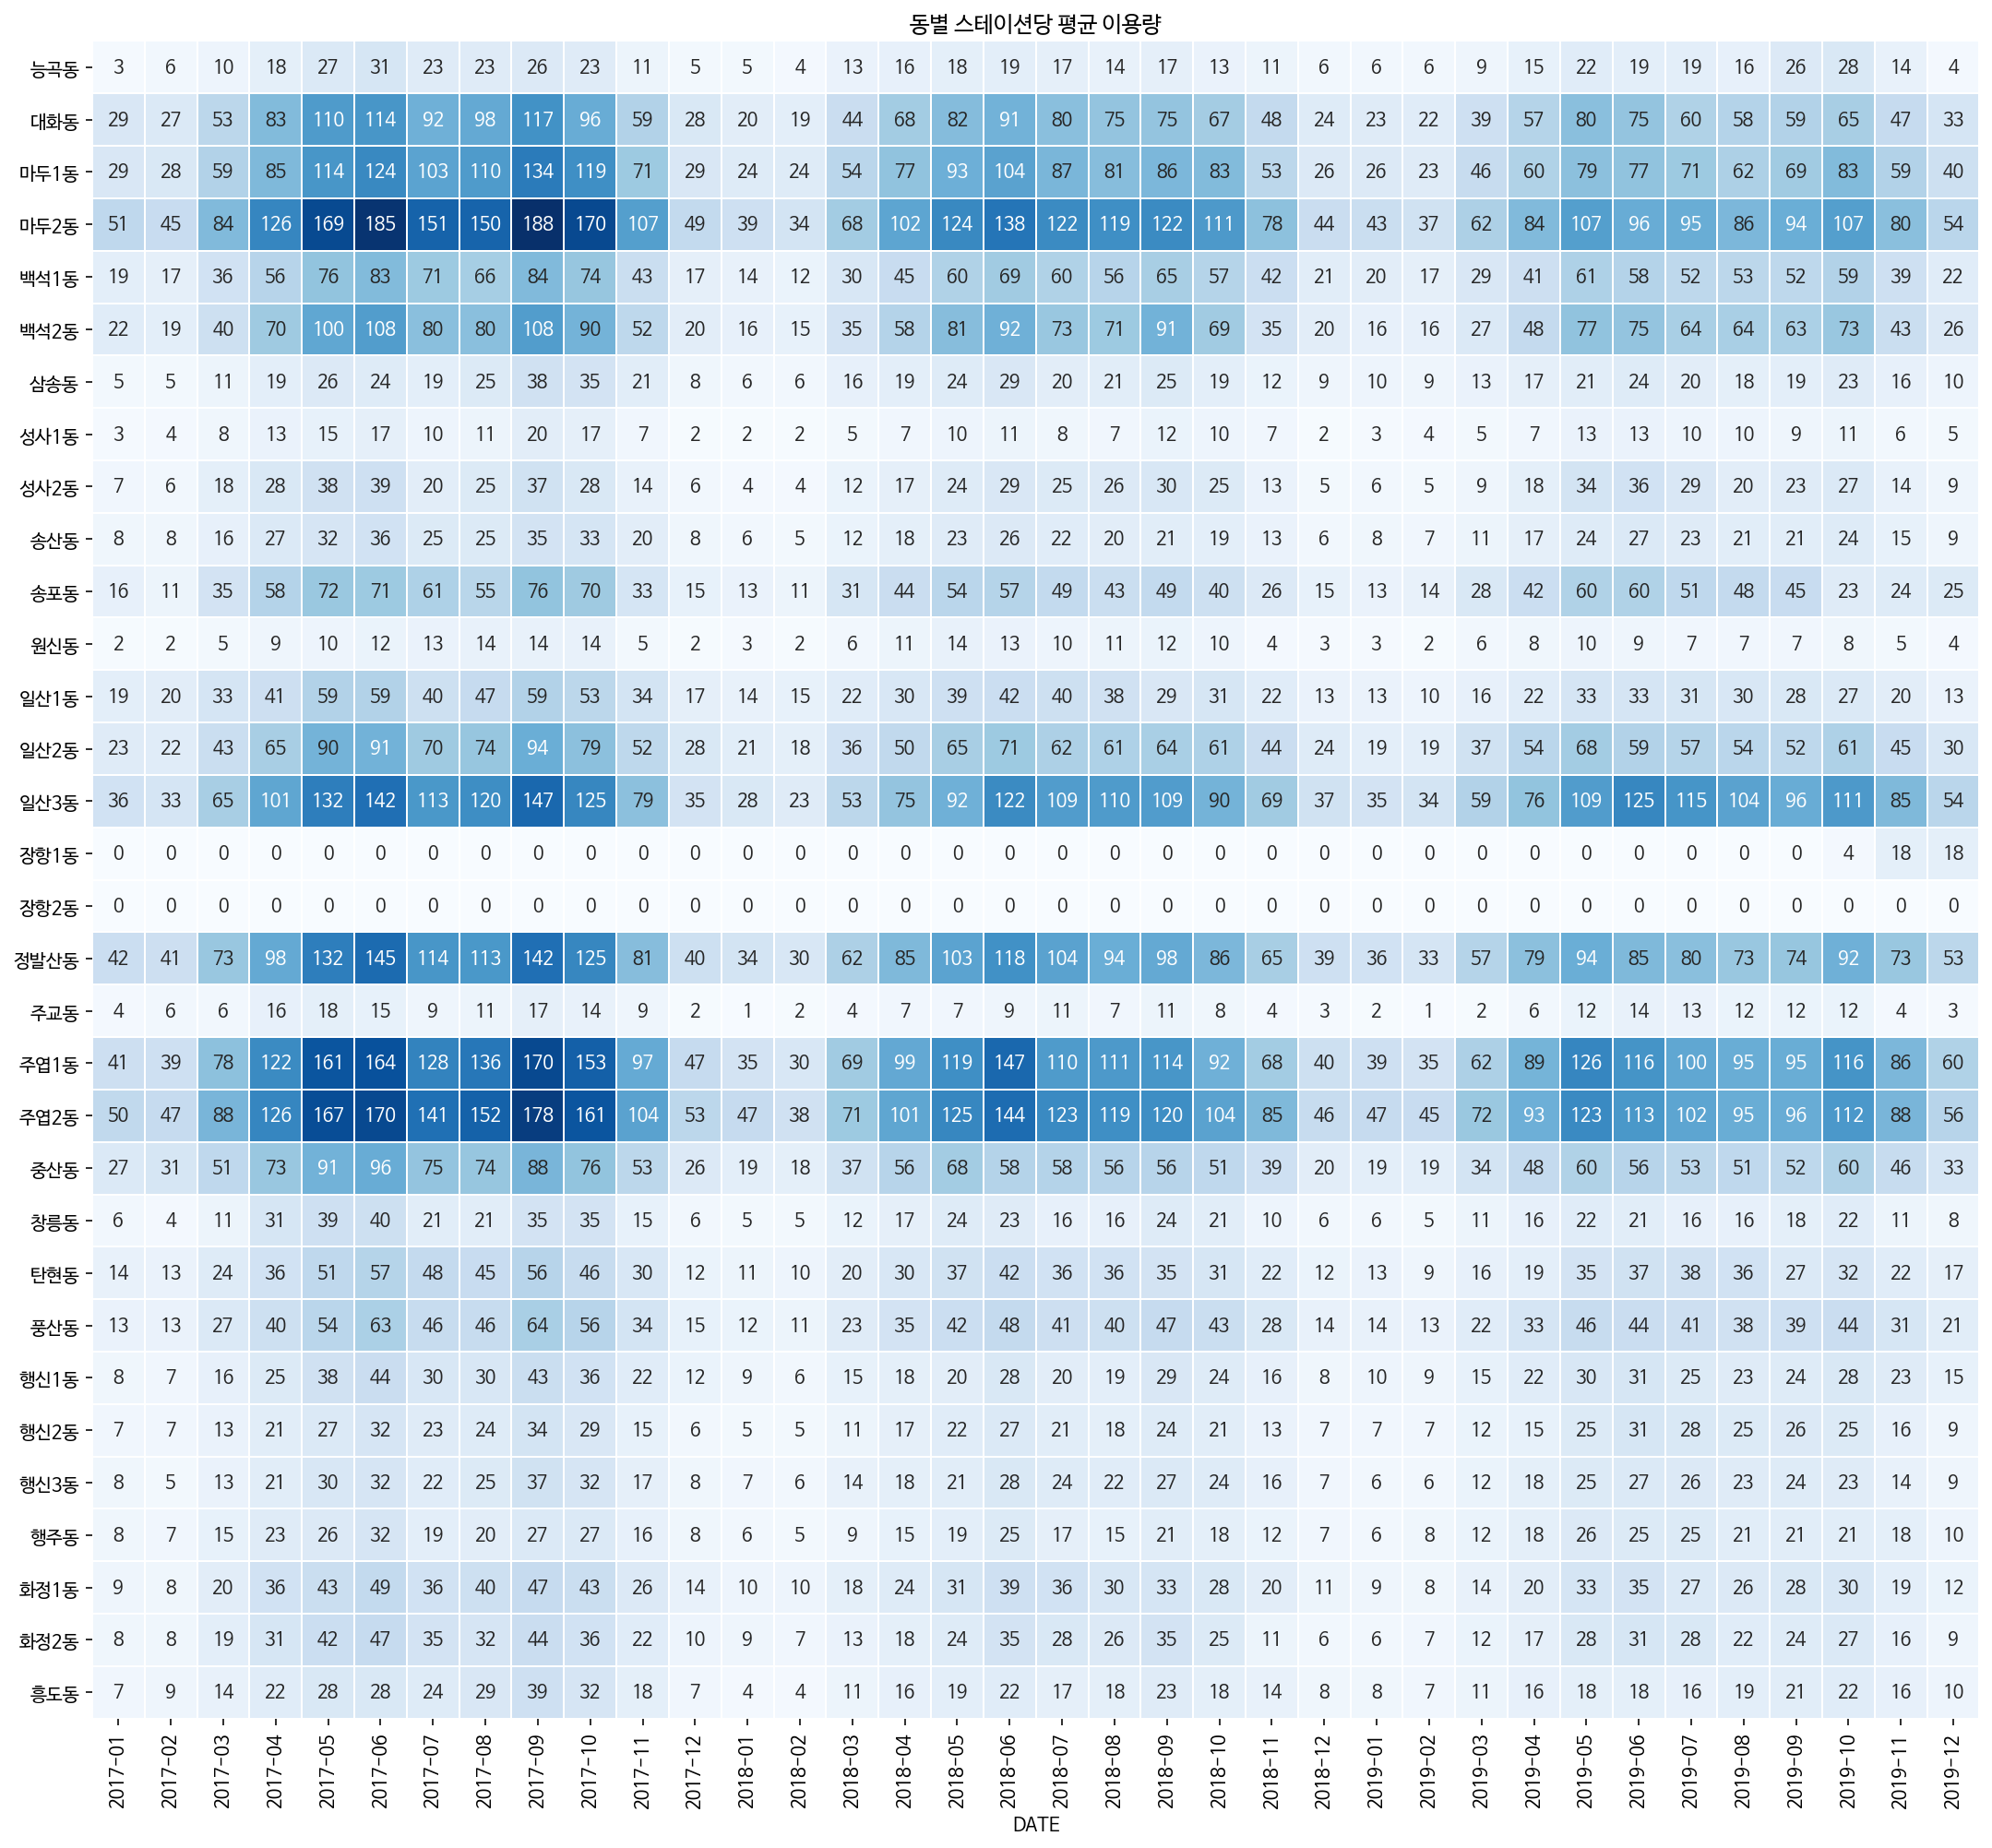

In [ ]:
unit = 10

plt.figure(figsize=(24, 14))
sns.heatmap((pvt_use_ratio/unit).astype('int'), square=True, cmap='Blues', linewidth=0.5, cbar=False, annot=True, fmt='d')
plt.title("동별 스테이션당 평균 이용량")
plt.ylabel("")
plt.tight_layout()
plt.show()

- 동별 대여량(히트맵) 그래프와 큰 부분에서는 비슷한 양상을 보인다.
- 하지만 전체 대여량을 평균으로 나눠보니 새롭게 보이는 사항들이 있다.
  - 마두2동, 주엽1동, 주엽2동에서 스테이션당 대여량이 가장 두드러지게 나타난다.

# 정리
- 피프틴의 이용률은 17년이 가장 높았고 점점 감소하고 있다.
- 호수공원에 위치한 장향2동의 스테이션의 이용량이 월등하게 높다.
- '동별 누적 대여량'과 '동별 스테이션당 평균 대여량'간에는 차이가 존재한다.
---
# 한계점 & 의문점
- 시간이 흐를수록 감소하는 사용량의 이유는 무엇일까?
  - 우리는 [0, 992, 998, 999] 범주에 해당하는 `Station_ID` 값을 제외했다.
  - 즉, 수리 및 분실로 처리된 자전거의 증가로 인해 전체적인 사용량이 매해 떨어지는 것인지 확인해볼 필요가 있다.
- '동별 누적 대여량'과 '동별 스테이션당 평균 대여량'간에 차이점이 존재했다.
  - 좀 더 생각해봐야겠음
- 호수공원지역 장향2동 반냡량이 월등히 높은 점을 어떻게 하면 해소할 수 있을까?

# EDA 3

## (7) 스테이션과 인구수

### (7).1 스테이션별 인구수 데이터처리

In [ ]:
#데이터 불러오기
df_6=gpd.read_file('/content/gdrive/My Drive/고양시피프틴/06.인구(거주)분포도(100M_X_100M).geojson')

In [ ]:
#Null값 0으로 변경
df_6['val']=df_6.val.fillna(0)
df_6_copy = df_6.copy()

In [ ]:
# 100 * 100 격자 내의 중심 좌표 출력
# x가 경도, y가 위도임 ㅠ
# 37.xxx / 127.xxx 찍어야 올바름
df_6_copy['x'] = np.array(df_6['geometry'].centroid.x)
df_6_copy['y'] = np.array(df_6['geometry'].centroid.y)                          
df_6_copy.head()

gid  val  ...           x          y
0  다사268650  0.0  ...  126.670407  37.682073
1  다사268651  0.0  ...  126.670397  37.682974
2  다사268652  0.0  ...  126.670387  37.683875
3  다사268653  0.0  ...  126.670377  37.684777
4  다사268654  0.0  ...  126.670367  37.685678

[5 rows x 5 columns]

In [ ]:
# 기존 스테이션 시각화
geo_path_6='/content/gdrive/My Drive/고양시피프틴/06.인구(거주)분포도(100M_X_100M).geojson'
geo_str_6=geojson.load(open(geo_path_6,encoding='utf-8'))
map_6 =folium.Map(location=[37.660686, 126.835563],zoom_start=12)     # 행정구역별 지도 test_map1 / 
folium.GeoJson(geo_str_6).add_to(map_6)

In [ ]:
# 중앙점 확인
# 격자랑 같이 찍으려면 노트북 런타임 초과남
for a in range(0,len(df_6_copy)):
  lat = df_6_copy.loc[a, 'y']
  long = df_6_copy.loc[a, 'x']
  center=folium.CircleMarker([lat,long],
                              radius=1,                        
                              color='red',
                              fill= True).add_to(map_6)

In [63]:
# 100*100의 좌표와 그 중심값으로 x,y가 정상적으로 대입되었다고 가정하고 진행
x=[]
y=[]
z=[]

for station in tqdm_notebook(df_2.index, desc = "자전거"):  # 스테이션 인덱스 만큼 loop
  for center_point in tqdm_notebook(df_6_copy.index, "중심값 좌표 비교"):  # 좌표 중심점만큼 loop
    start_long = df_2['위도'][station]
    start_lat = df_2['경도'][station]  # 스테이션 위치
    goal_long = df_6_copy['y'][center_point]
    goal_lat = df_6_copy['x'][center_point]  # 중심점 위치
    haver=haversine(start_long, start_lat, goal_long ,goal_lat)  # m단위로 거리측정
    if (haver <= 300):  # '300미터 이내'라는 조건 추가
      x.append(df_2['Station_ID'][station]) # 조건에 부합하면 그 시점의 id 저장
      y.append(df_6_copy['val'][center_point]) # 그 시점의 인원수 저장
      #z.append(goal)

station_pop = pd.DataFrame([x,y]).T  # z추가                                                    
station_pop.columns=['Station_ID','val']
station_pop.sort_values('Station_ID')
station_pop

Station_ID    val
0          101.0  339.0
1          101.0  139.0
2          101.0  103.0
3          101.0    0.0
4          101.0    0.0
...          ...    ...
6077       992.0  301.0
6078       992.0  260.0
6079       992.0    0.0
6080       992.0    0.0
6081       992.0  231.0

[6082 rows x 2 columns]

In [64]:
# 스테이션별 인원수 합계
p_result=station_pop.groupby('Station_ID').sum().reset_index()
p_result.columns=['Station_ID','population']
p_result

Station_ID  population
0         101.0      9841.0
1         103.0     12000.0
2         104.0     13426.0
3         105.0      9395.0
4         106.0      3780.0
..          ...         ...
159       350.0      9332.0
160       351.0     11573.0
161       352.0      7954.0
162       353.0      8486.0
163       992.0      7597.0

[164 rows x 2 columns]

In [69]:
station=pd.merge(station,p_result,on='Station_ID')
station

gu  dong Station_ID  ...          경도         위도  population
0     고양시덕양구  성사2동        101  ...  126.834584  37.654775      9841.0
1     고양시덕양구  성사1동        103  ...  126.840377  37.660442     12000.0
2    고양시일산서구   탄현동        104  ...  126.766042  37.698523     13426.0
3     고양시덕양구  성사1동        105  ...  126.839261  37.655244      9395.0
4     고양시덕양구  성사1동        106  ...  126.842530  37.653410      3780.0
..       ...   ...        ...  ...         ...        ...         ...
159  고양시일산서구   송산동        350  ...  126.753089  37.697867      9332.0
160  고양시일산서구   탄현동        351  ...  126.767231  37.702259     11573.0
161  고양시일산서구   대화동        352  ...  126.749244  37.666425      7954.0
162  고양시일산서구   대화동        353  ...  126.750784  37.666720      8486.0
163   고양시덕양구  화정1동        992  ...  126.833760  37.637529      7597.0

[164 rows x 8 columns]

### (7).2 스테이션별 인구수 시각화

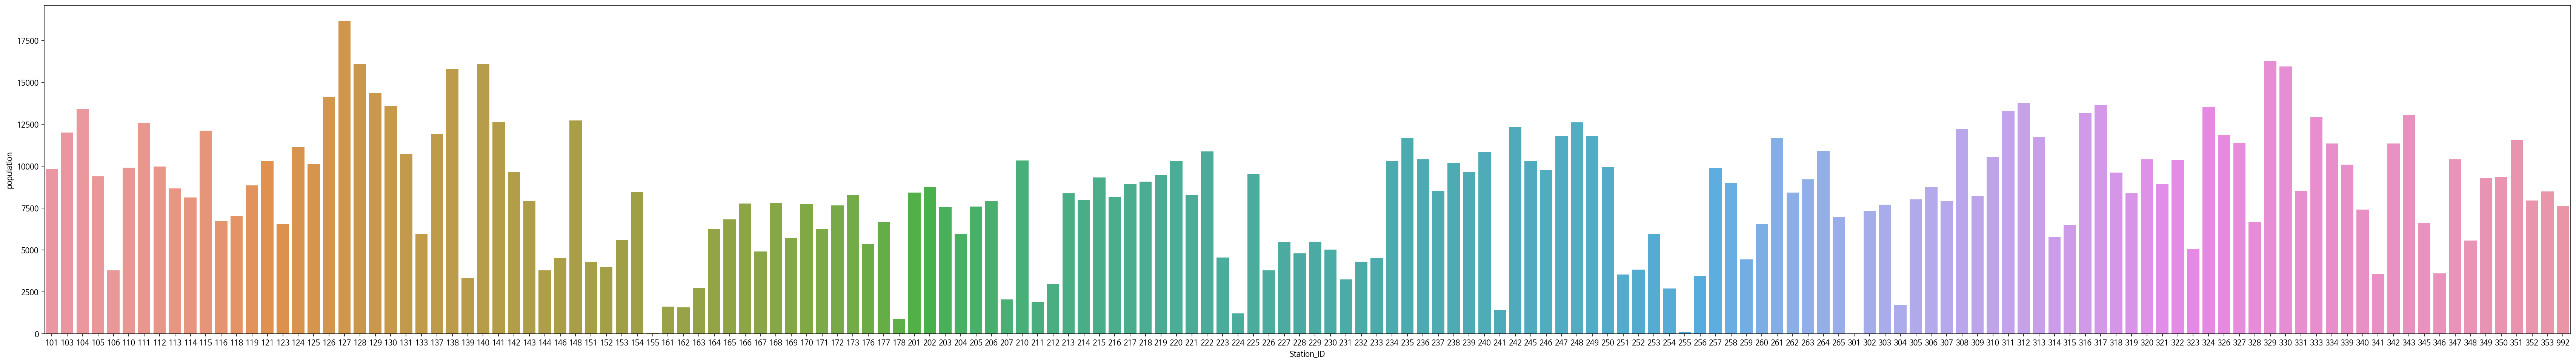

In [70]:
plt.figure(figsize=(60,8)) #size 조절
#plt.xticks(rotation = 50) #x축 조절
sns.barplot(data = station.sort_values(by='gu'), x = "Station_ID", y = "population")
plt.show()

### (7).3 스테이션별 인구수 대비 거치대 수량 시각화

In [71]:
station['population/거치대 수량']=station['population']/station['거치대 수량']
station[station['dong']=='장항1동']


gu  dong Station_ID  ...         위도  population  population/거치대 수량
114  고양시일산서구  장항1동        263  ...  37.661579      9208.0            230.200
116  고양시일산동구  장항1동        265  ...  37.661296      6977.0            174.425

[2 rows x 9 columns]

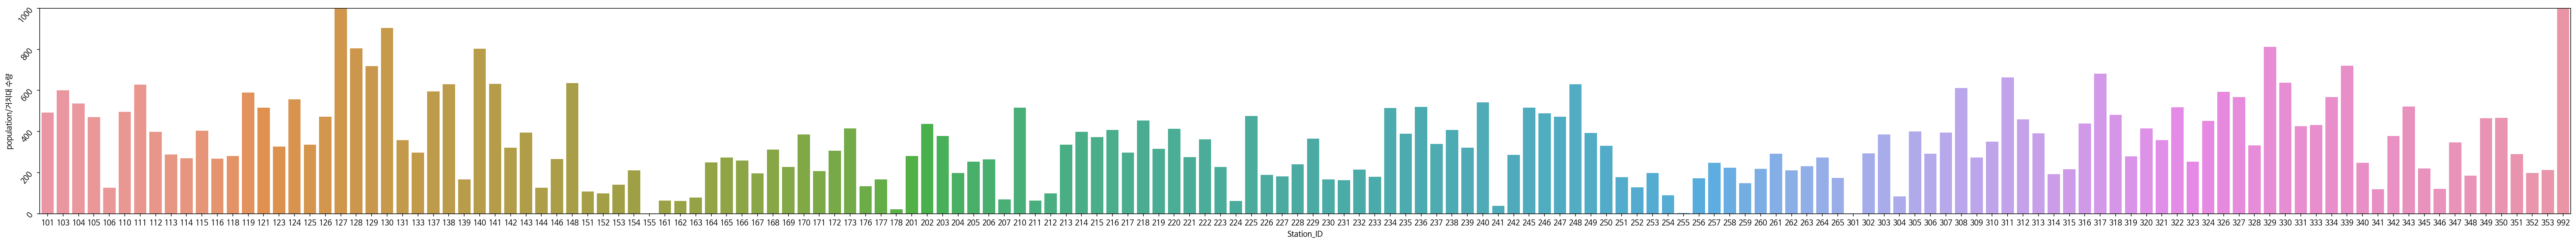

In [72]:
plt.figure(figsize=(60,5)) #size 조절
plt.yticks(rotation = 50)
plt.ylim(0,1000)
sns.barplot(data = station.sort_values(by='gu'), x = "Station_ID", y = "population/거치대 수량")
plt.show()

### (7).4 스테이션별 인구수 대비 대여량

In [73]:
station_leas_rtn.groupby(['Station_ID']).sum()['LEAS_COUNT']

Station_ID
101     7244
103     3737
104    11557
105     2205
106     3685
       ...  
348     3546
349     6008
350     3396
351      334
992      485
Name: LEAS_COUNT, Length: 155, dtype: int64

In [74]:
station_leas=station_leas_rtn.groupby(['Station_ID']).sum()['LEAS_COUNT'].reset_index()
station_leas['LEAS_COUNT']=station_leas['LEAS_COUNT']/36
station_leas

Station_ID  LEAS_COUNT
0           101  201.222222
1           103  103.805556
2           104  321.027778
3           105   61.250000
4           106  102.361111
..          ...         ...
150         348   98.500000
151         349  166.888889
152         350   94.333333
153         351    9.277778
154         992   13.472222

[155 rows x 2 columns]

In [75]:
station_leas_p=pd.merge(station_leas,station[['Station_ID',"population"]],on='Station_ID')
station_leas_p['population/LEAS_COUNT']=station_leas_p['population']/station_leas_p['LEAS_COUNT']
station_leas_p.sort_values(by='population/LEAS_COUNT',ascending=False)

Station_ID   LEAS_COUNT  population  population/LEAS_COUNT
107        263     5.055556      9208.0            1821.362637
153        351     9.277778     11573.0            1247.389222
108        264    14.916667     10899.0             730.659218
154        992    13.472222      7597.0             563.901031
109        265    18.083333      6977.0             385.824885
..         ...          ...         ...                    ...
57         207  1122.861111      2050.0               1.825693
59         211  1356.055556      1908.0               1.407022
98         254  1994.361111      2706.0               1.356825
99         255   163.611111        88.0               0.537861
110        301   216.833333        23.0               0.106072

[155 rows x 4 columns]

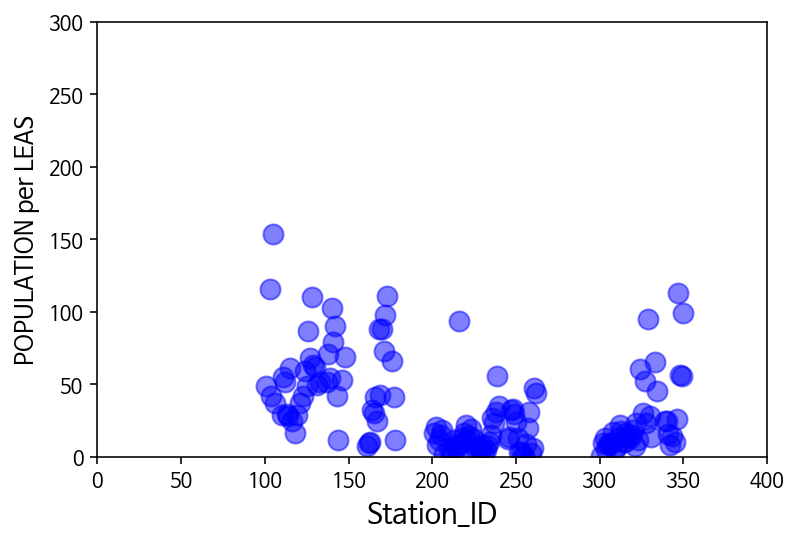

In [76]:

plt.plot('Station_ID',  # x
         'population/LEAS_COUNT',  # y
         data=station_leas_p,
         linestyle='none', 
         marker='o', 
         markersize=10,
         color='blue', 
         alpha=0.5)
plt.xlim(0,400)
plt.ylim(0,300)

plt.xlabel('Station_ID', fontsize=14)
plt.ylabel('POPULATION per LEAS', fontsize=12)
plt.show()